# Classification with Virtual Branching

In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
from vbranch.callbacks import classification_acc
from vbranch.applications.fcn import FCN
from vbranch.applications.cnn import CNN
from vbranch.losses import softmax_cross_entropy_with_logits

from vbranch.utils import TFSessionGrow, restore_sess
from vbranch.utils.training import get_data, bag_samples, get_data_iterator
from vbranch.utils.generic import get_path, save_results

Using TensorFlow backend.


In [3]:
MODEL_ID = 1
ARCHITECTURE = 'fcn3A'
DATASET = 'mnist'
NUM_CLASSES = 10
NUM_FEATURES = None
SAMPLES_PER_CLASS = None
BAGGING_SAMPLES = 1.
TRAIN_FRAC = 0.01

BATCH_SIZE = 32
EPOCHS = 10
STEPS_PER_EPOCH = 100

## Data

In [4]:
(X_train, y_train), (X_test, y_test) = get_data(DATASET, ARCHITECTURE, NUM_CLASSES,
                                                NUM_FEATURES, SAMPLES_PER_CLASS, 
                                                train_frac=TRAIN_FRAC)
# Bagging
if BAGGING_SAMPLES < 1:
    x_train_list, y_train_list = bag_samples(X_train, y_train, NUM_BRANCHES, 
                                             max_samples=BAGGING_SAMPLES)
    
x_shape = (None,) + X_train.shape[1:]
y_shape = (None, NUM_CLASSES)

## Training

In [5]:
def path(n_branches, shared_frac):
    return get_path(DATASET, ARCHITECTURE, 'sensitivity', vb=True, 
                    B=n_branches, S=shared_frac)

In [6]:
def build_model(n_branches, shared_frac, name='model'):
    inputs, labels, train_init_op, test_init_op = get_data_iterator(x_shape, y_shape, 
                                                                    batch_size=BATCH_SIZE, 
                                                                    n=n_branches, 
                                                                    share_xy=BAGGING_SAMPLES == 1)
    with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
        if ARCHITECTURE == 'fcn':
            layer_spec = [(512, shared_frac), NUM_CLASSES]
        elif ARCHITECTURE == 'fcn2':
            layer_spec = [(512, shared_frac), 512, NUM_CLASSES]
        elif ARCHITECTURE == 'fcn3':
            layer_spec = [(512, shared_frac), 512, 512, NUM_CLASSES]
        elif ARCHITECTURE == 'fcn2A':
            layer_spec = [(512, shared_frac), (512, shared_frac), (NUM_CLASSES, shared_frac)]
        elif ARCHITECTURE == 'fcn3A':
            layer_spec = [(512, shared_frac), (512, shared_frac), 
                          (512, shared_frac), (NUM_CLASSES, shared_frac)]
        else:
            raise ValueError('invalid model')
            
        model = FCN(inputs, *layer_spec, name=name, shared_frac=1)
#         elif ARCHITECTURE == 'cnn':
#             model = SimpleCNNSmall(inputs, NUM_CLASSES, name=name, shared_frac=shared_frac)

        optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
        model.compile(optimizer, softmax_cross_entropy_with_logits(), 
                      train_init_op, test_init_op, labels=labels, 
                      callbacks={'acc':classification_acc(n_branches)})

    return model

In [7]:
def train(n_branches, shared_frac, model_id=1):
    dirpath = path(n_branches, shared_frac)
    print(dirpath)
    
    tf.reset_default_graph()
    model = build_model(n_branches, shared_frac)
    model.summary()

    if n_branches == 1 or BAGGING_SAMPLES == 1:
        train_dict = {'x:0': X_train, 'y:0': y_train, 'batch_size:0': BATCH_SIZE}
    else:
        train_dict = {}
        for i in range(n_branches):
            train_dict['vb{}_x:0'.format(i+1)] = x_train_list[i]
            train_dict['vb{}_y:0'.format(i+1)] = y_train_list[i]
        train_dict['batch_size:0'] = BATCH_SIZE

    val_dict = {'x:0': X_test, 'y:0': y_test, 'batch_size:0': len(X_test)}

    model_path = os.path.join('models', dirpath, 'model_{}'.format(model_id))
    os.system('mkdir -p ' + model_path)
    history = model.fit(EPOCHS, STEPS_PER_EPOCH, train_dict=train_dict,
                        val_dict=val_dict, log_path=model_path)
    save_results(history, dirpath, 'train_{}.csv'.format(model_id))
    
    return history

In [8]:
for n_branches in range(2, 7):
    for shared_frac in [0., 0.25, 0.5, 0.75, 1.]:
        for t in range(4):
            train(n_branches, shared_frac, model_id=t+1)

sensitivity/vb-mnist-fcn3A/B2/S0.00
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
i  Layer name                Output shape   Num param  Inbound  
----------------------------------------------------------------
   Input                     [None,784]                         
----------------------------------------------------------------
   Input                     [None,784]                         
----------------------------------------------------------------
0  fc1 (Dense)               [] [None,512]  803840     input    
                             [] [None,512]                      
----------------------------------------------------------------
1  bn1 (BatchNormalization)  [] [None,512]  2048       fc1      
                             [] [None,512]                      
----------------------------------------------------------------
2  relu1 (Activation)        [] [None,512]  0          bn1      

Epoch 4/10
 - 1s - loss_1: 9.5622e-04 - loss_2: 5.9037e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - val_loss_1: 0.3783 - val_loss_2: 0.3503 - val_acc_ensemble: 0.9091 - val_acc_1: 0.8977 - val_acc_2: 0.9034
Epoch 5/10
 - 1s - loss_1: 4.8448e-04 - loss_2: 4.1629e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - val_loss_1: 0.3772 - val_loss_2: 0.3534 - val_acc_ensemble: 0.9087 - val_acc_1: 0.8980 - val_acc_2: 0.9030
Epoch 6/10
 - 1s - loss_1: 3.2794e-04 - loss_2: 3.1385e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - val_loss_1: 0.3779 - val_loss_2: 0.3565 - val_acc_ensemble: 0.9089 - val_acc_1: 0.8985 - val_acc_2: 0.9037
Epoch 7/10
 - 1s - loss_1: 2.2993e-04 - loss_2: 2.6107e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - val_loss_1: 0.3801 - val_loss_2: 0.3591 - val_acc_ensemble: 0.9085 - val_acc_1: 0.8989 - val_acc_2: 0.9037
Epoch 8/10
 - 1s - loss_1: 2.1094e-04 - loss_2: 2.0812e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1

 - 1s - loss_1: 0.2295 - loss_2: 0.2216 - acc_ensemble: 1.0000 - acc_1: 0.9967 - acc_2: 1.0000 - val_loss_1: 0.4755 - val_loss_2: 0.3891 - val_acc_ensemble: 0.8977 - val_acc_1: 0.8662 - val_acc_2: 0.8874
Epoch 2/10
 - 1s - loss_1: 0.0044 - loss_2: 0.0029 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - val_loss_1: 0.3738 - val_loss_2: 0.3668 - val_acc_ensemble: 0.9057 - val_acc_1: 0.8966 - val_acc_2: 0.8969
Epoch 3/10
 - 1s - loss_1: 9.0261e-04 - loss_2: 8.4836e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - val_loss_1: 0.3736 - val_loss_2: 0.3653 - val_acc_ensemble: 0.9060 - val_acc_1: 0.8976 - val_acc_2: 0.9001
Epoch 4/10
 - 1s - loss_1: 5.3343e-04 - loss_2: 5.4641e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - val_loss_1: 0.3745 - val_loss_2: 0.3668 - val_acc_ensemble: 0.9073 - val_acc_1: 0.8991 - val_acc_2: 0.8996
Epoch 5/10
 - 1s - loss_1: 4.1399e-04 - loss_2: 4.0798e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - val_loss_1: 0.3749 

Epoch 1/10
 - 2s - loss_1: 0.2401 - loss_2: 0.2403 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - val_loss_1: 0.3771 - val_loss_2: 0.3961 - val_acc_ensemble: 0.9017 - val_acc_1: 0.8966 - val_acc_2: 0.8898
Epoch 2/10
 - 1s - loss_1: 0.0025 - loss_2: 0.0098 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - val_loss_1: 0.3678 - val_loss_2: 0.3854 - val_acc_ensemble: 0.9061 - val_acc_1: 0.8995 - val_acc_2: 0.8979
Epoch 3/10
 - 1s - loss_1: 7.5635e-04 - loss_2: 9.2750e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - val_loss_1: 0.3696 - val_loss_2: 0.3812 - val_acc_ensemble: 0.9069 - val_acc_1: 0.9007 - val_acc_2: 0.9015
Epoch 4/10
 - 1s - loss_1: 4.9854e-04 - loss_2: 4.8844e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - val_loss_1: 0.3713 - val_loss_2: 0.3808 - val_acc_ensemble: 0.9080 - val_acc_1: 0.9025 - val_acc_2: 0.9024
Epoch 5/10
 - 1s - loss_1: 3.5842e-04 - loss_2: 3.4768e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - val_loss

Epoch 1/10
 - 2s - loss_1: 0.2314 - loss_2: 0.2379 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - val_loss_1: 0.4085 - val_loss_2: 0.3941 - val_acc_ensemble: 0.9001 - val_acc_1: 0.8859 - val_acc_2: 0.8880
Epoch 2/10
 - 1s - loss_1: 0.0028 - loss_2: 0.0028 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - val_loss_1: 0.3845 - val_loss_2: 0.3650 - val_acc_ensemble: 0.9068 - val_acc_1: 0.8956 - val_acc_2: 0.8995
Epoch 3/10
 - 1s - loss_1: 7.2102e-04 - loss_2: 7.2901e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - val_loss_1: 0.3801 - val_loss_2: 0.3682 - val_acc_ensemble: 0.9063 - val_acc_1: 0.8993 - val_acc_2: 0.9004
Epoch 4/10
 - 1s - loss_1: 4.7519e-04 - loss_2: 4.7012e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - val_loss_1: 0.3813 - val_loss_2: 0.3719 - val_acc_ensemble: 0.9060 - val_acc_1: 0.9006 - val_acc_2: 0.9009
Epoch 5/10
 - 1s - loss_1: 3.3813e-04 - loss_2: 3.4131e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - val_loss

Epoch 1/10
 - 2s - loss_1: 0.2205 - loss_2: 0.2198 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 0.9967 - val_loss_1: 0.4219 - val_loss_2: 0.4837 - val_acc_ensemble: 0.8858 - val_acc_1: 0.8832 - val_acc_2: 0.8662
Epoch 2/10
 - 1s - loss_1: 0.0029 - loss_2: 0.0066 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - val_loss_1: 0.3886 - val_loss_2: 0.4217 - val_acc_ensemble: 0.9012 - val_acc_1: 0.8982 - val_acc_2: 0.8917
Epoch 3/10
 - 1s - loss_1: 6.6874e-04 - loss_2: 7.3267e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - val_loss_1: 0.3897 - val_loss_2: 0.4194 - val_acc_ensemble: 0.9033 - val_acc_1: 0.8994 - val_acc_2: 0.8936
Epoch 4/10
 - 1s - loss_1: 4.5221e-04 - loss_2: 4.3233e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - val_loss_1: 0.3932 - val_loss_2: 0.4237 - val_acc_ensemble: 0.9034 - val_acc_1: 0.8999 - val_acc_2: 0.8951
Epoch 5/10
 - 1s - loss_1: 3.0890e-04 - loss_2: 2.9482e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - val_loss

Epoch 1/10
 - 3s - loss_1: 0.2296 - loss_2: 0.2160 - acc_ensemble: 1.0000 - acc_1: 0.9983 - acc_2: 1.0000 - val_loss_1: 0.4267 - val_loss_2: 0.4219 - val_acc_ensemble: 0.8914 - val_acc_1: 0.8831 - val_acc_2: 0.8806
Epoch 2/10
 - 1s - loss_1: 0.0037 - loss_2: 0.0025 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - val_loss_1: 0.3855 - val_loss_2: 0.3821 - val_acc_ensemble: 0.9036 - val_acc_1: 0.9002 - val_acc_2: 0.8937
Epoch 3/10
 - 1s - loss_1: 6.4054e-04 - loss_2: 6.7489e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - val_loss_1: 0.3860 - val_loss_2: 0.3826 - val_acc_ensemble: 0.9039 - val_acc_1: 0.9023 - val_acc_2: 0.8953
Epoch 4/10
 - 1s - loss_1: 4.2713e-04 - loss_2: 4.1936e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - val_loss_1: 0.3893 - val_loss_2: 0.3853 - val_acc_ensemble: 0.9044 - val_acc_1: 0.9023 - val_acc_2: 0.8960
Epoch 5/10
 - 1s - loss_1: 3.0472e-04 - loss_2: 3.2194e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - val_loss

Epoch 1/10
 - 2s - loss_1: 0.1876 - loss_2: 0.1863 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 0.9983 - val_loss_1: 0.3869 - val_loss_2: 0.3927 - val_acc_ensemble: 0.8968 - val_acc_1: 0.8917 - val_acc_2: 0.8924
Epoch 2/10
 - 1s - loss_1: 0.0016 - loss_2: 0.0015 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - val_loss_1: 0.3679 - val_loss_2: 0.3725 - val_acc_ensemble: 0.9032 - val_acc_1: 0.8998 - val_acc_2: 0.9014
Epoch 3/10
 - 1s - loss_1: 5.7595e-04 - loss_2: 5.3032e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - val_loss_1: 0.3719 - val_loss_2: 0.3775 - val_acc_ensemble: 0.9037 - val_acc_1: 0.9006 - val_acc_2: 0.9010
Epoch 4/10
 - 1s - loss_1: 3.9221e-04 - loss_2: 3.4917e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - val_loss_1: 0.3751 - val_loss_2: 0.3817 - val_acc_ensemble: 0.9042 - val_acc_1: 0.9016 - val_acc_2: 0.9011
Epoch 5/10
 - 1s - loss_1: 2.8794e-04 - loss_2: 2.5604e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - val_loss

Epoch 1/10
 - 2s - loss_1: 0.2120 - loss_2: 0.1951 - acc_ensemble: 0.9983 - acc_1: 0.9950 - acc_2: 0.9983 - val_loss_1: 0.4562 - val_loss_2: 0.4162 - val_acc_ensemble: 0.8845 - val_acc_1: 0.8740 - val_acc_2: 0.8870
Epoch 2/10
 - 1s - loss_1: 0.0019 - loss_2: 0.0018 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - val_loss_1: 0.3971 - val_loss_2: 0.3967 - val_acc_ensemble: 0.8988 - val_acc_1: 0.8936 - val_acc_2: 0.8977
Epoch 3/10
 - 1s - loss_1: 6.6911e-04 - loss_2: 6.3748e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - val_loss_1: 0.3941 - val_loss_2: 0.3948 - val_acc_ensemble: 0.9013 - val_acc_1: 0.8945 - val_acc_2: 0.8999
Epoch 4/10
 - 1s - loss_1: 4.0722e-04 - loss_2: 4.0373e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - val_loss_1: 0.3944 - val_loss_2: 0.3958 - val_acc_ensemble: 0.9020 - val_acc_1: 0.8956 - val_acc_2: 0.9000
Epoch 5/10
 - 1s - loss_1: 3.1012e-04 - loss_2: 2.8157e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - val_loss

 - 1s - loss_1: 0.1292 - loss_2: 0.1537 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - val_loss_1: 0.3719 - val_loss_2: 0.3719 - val_acc_ensemble: 0.8922 - val_acc_1: 0.8922 - val_acc_2: 0.8922
Epoch 2/10
 - 1s - loss_1: 0.0014 - loss_2: 0.0014 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - val_loss_1: 0.3688 - val_loss_2: 0.3688 - val_acc_ensemble: 0.8956 - val_acc_1: 0.8956 - val_acc_2: 0.8956
Epoch 3/10
 - 1s - loss_1: 7.1356e-04 - loss_2: 7.0378e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - val_loss_1: 0.3700 - val_loss_2: 0.3700 - val_acc_ensemble: 0.8973 - val_acc_1: 0.8973 - val_acc_2: 0.8973
Epoch 4/10
 - 1s - loss_1: 4.6154e-04 - loss_2: 4.7641e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - val_loss_1: 0.3726 - val_loss_2: 0.3726 - val_acc_ensemble: 0.8978 - val_acc_1: 0.8978 - val_acc_2: 0.8978
Epoch 5/10
 - 1s - loss_1: 3.4478e-04 - loss_2: 3.3317e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - val_loss_1: 0.3752 

 - 1s - loss_1: 0.1306 - loss_2: 0.1394 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - val_loss_1: 0.3572 - val_loss_2: 0.3572 - val_acc_ensemble: 0.8931 - val_acc_1: 0.8931 - val_acc_2: 0.8931
Epoch 2/10
 - 1s - loss_1: 0.0014 - loss_2: 0.0014 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - val_loss_1: 0.3572 - val_loss_2: 0.3572 - val_acc_ensemble: 0.8950 - val_acc_1: 0.8950 - val_acc_2: 0.8950
Epoch 3/10
 - 1s - loss_1: 7.0336e-04 - loss_2: 6.8807e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - val_loss_1: 0.3574 - val_loss_2: 0.3574 - val_acc_ensemble: 0.8971 - val_acc_1: 0.8971 - val_acc_2: 0.8971
Epoch 4/10
 - 1s - loss_1: 4.2767e-04 - loss_2: 4.1880e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - val_loss_1: 0.3601 - val_loss_2: 0.3601 - val_acc_ensemble: 0.8981 - val_acc_1: 0.8981 - val_acc_2: 0.8981
Epoch 5/10
 - 1s - loss_1: 3.0484e-04 - loss_2: 3.2210e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - val_loss_1: 0.3628 

sensitivity/vb-mnist-fcn3A/B3/S0.00
i  Layer name                Output shape   Num param  Inbound  
----------------------------------------------------------------
   Input                     [None,784]                         
----------------------------------------------------------------
   Input                     [None,784]                         
----------------------------------------------------------------
   Input                     [None,784]                         
----------------------------------------------------------------
0  fc1 (Dense)               [] [None,512]  1205760    input    
                             [] [None,512]                      
                             [] [None,512]                      
----------------------------------------------------------------
1  bn1 (BatchNormalization)  [] [None,512]  3072       fc1      
                             [] [None,512]                      
                             [] [None,512]            

Epoch 1/10
 - 1s - loss_1: 0.2188 - loss_2: 0.2353 - loss_3: 0.2543 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 0.9967 - acc_3: 0.9933 - val_loss_1: 0.4152 - val_loss_2: 0.4202 - val_loss_3: 0.4011 - val_acc_ensemble: 0.9040 - val_acc_1: 0.8845 - val_acc_2: 0.8829 - val_acc_3: 0.8858
Epoch 2/10
 - 1s - loss_1: 0.0038 - loss_2: 0.0085 - loss_3: 0.0057 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 0.9983 - acc_3: 1.0000 - val_loss_1: 0.4089 - val_loss_2: 0.4184 - val_loss_3: 0.3722 - val_acc_ensemble: 0.9069 - val_acc_1: 0.8901 - val_acc_2: 0.8906 - val_acc_3: 0.8996
Epoch 3/10
 - 1s - loss_1: 7.4531e-04 - loss_2: 0.0012 - loss_3: 9.0949e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - val_loss_1: 0.4044 - val_loss_2: 0.3967 - val_loss_3: 0.3700 - val_acc_ensemble: 0.9095 - val_acc_1: 0.8918 - val_acc_2: 0.8991 - val_acc_3: 0.9021
Epoch 4/10
 - 1s - loss_1: 4.6028e-04 - loss_2: 5.1876e-04 - loss_3: 5.2962e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_

Epoch 8/10
 - 1s - loss_1: 1.9025e-04 - loss_2: 1.8673e-04 - loss_3: 1.8235e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - val_loss_1: 0.3706 - val_loss_2: 0.3837 - val_loss_3: 0.3670 - val_acc_ensemble: 0.9125 - val_acc_1: 0.9027 - val_acc_2: 0.9029 - val_acc_3: 0.9039
Epoch 9/10
 - 1s - loss_1: 1.6330e-04 - loss_2: 1.6554e-04 - loss_3: 1.4334e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - val_loss_1: 0.3720 - val_loss_2: 0.3850 - val_loss_3: 0.3689 - val_acc_ensemble: 0.9125 - val_acc_1: 0.9032 - val_acc_2: 0.9029 - val_acc_3: 0.9041
Epoch 10/10
 - 1s - loss_1: 1.3414e-04 - loss_2: 1.3440e-04 - loss_3: 1.2755e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - val_loss_1: 0.3739 - val_loss_2: 0.3867 - val_loss_3: 0.3707 - val_acc_ensemble: 0.9125 - val_acc_1: 0.9036 - val_acc_2: 0.9030 - val_acc_3: 0.9041
sensitivity/vb-mnist-fcn3A/B3/S0.25
i  Layer name                Output shape           Num para

Epoch 1/10
 - 4s - loss_1: 0.2408 - loss_2: 0.2360 - loss_3: 0.2298 - acc_ensemble: 1.0000 - acc_1: 0.9983 - acc_2: 0.9983 - acc_3: 0.9983 - val_loss_1: 0.4116 - val_loss_2: 0.4763 - val_loss_3: 0.4360 - val_acc_ensemble: 0.8974 - val_acc_1: 0.8811 - val_acc_2: 0.8704 - val_acc_3: 0.8840
Epoch 2/10
 - 1s - loss_1: 0.0022 - loss_2: 0.0027 - loss_3: 0.0025 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - val_loss_1: 0.3852 - val_loss_2: 0.3973 - val_loss_3: 0.4033 - val_acc_ensemble: 0.9060 - val_acc_1: 0.8956 - val_acc_2: 0.9002 - val_acc_3: 0.8955
Epoch 3/10
 - 1s - loss_1: 6.7695e-04 - loss_2: 6.4056e-04 - loss_3: 7.1047e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - val_loss_1: 0.3851 - val_loss_2: 0.3966 - val_loss_3: 0.4015 - val_acc_ensemble: 0.9071 - val_acc_1: 0.8975 - val_acc_2: 0.9024 - val_acc_3: 0.8982
Epoch 4/10
 - 2s - loss_1: 4.3985e-04 - loss_2: 4.0377e-04 - loss_3: 4.5637e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - 

Epoch 7/10
 - 1s - loss_1: 1.8831e-04 - loss_2: 1.8811e-04 - loss_3: 1.8657e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - val_loss_1: 0.3867 - val_loss_2: 0.4122 - val_loss_3: 0.4063 - val_acc_ensemble: 0.9093 - val_acc_1: 0.9004 - val_acc_2: 0.8990 - val_acc_3: 0.9035
Epoch 8/10
 - 2s - loss_1: 1.6988e-04 - loss_2: 1.6260e-04 - loss_3: 1.6190e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - val_loss_1: 0.3893 - val_loss_2: 0.4139 - val_loss_3: 0.4085 - val_acc_ensemble: 0.9097 - val_acc_1: 0.9006 - val_acc_2: 0.8993 - val_acc_3: 0.9035
Epoch 9/10
 - 1s - loss_1: 1.3765e-04 - loss_2: 1.3992e-04 - loss_3: 1.3530e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - val_loss_1: 0.3904 - val_loss_2: 0.4154 - val_loss_3: 0.4101 - val_acc_ensemble: 0.9098 - val_acc_1: 0.9007 - val_acc_2: 0.8990 - val_acc_3: 0.9040
Epoch 10/10
 - 1s - loss_1: 1.1626e-04 - loss_2: 1.2167e-04 - loss_3: 1.1320e-04 - acc_ensemble: 

Epoch 1/10
 - 4s - loss_1: 0.2211 - loss_2: 0.2291 - loss_3: 0.2245 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 0.9983 - acc_3: 0.9983 - val_loss_1: 0.3948 - val_loss_2: 0.4346 - val_loss_3: 0.4270 - val_acc_ensemble: 0.8983 - val_acc_1: 0.8930 - val_acc_2: 0.8858 - val_acc_3: 0.8865
Epoch 2/10
 - 1s - loss_1: 0.0016 - loss_2: 0.0070 - loss_3: 0.0019 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - val_loss_1: 0.3928 - val_loss_2: 0.4339 - val_loss_3: 0.4154 - val_acc_ensemble: 0.9019 - val_acc_1: 0.8975 - val_acc_2: 0.8910 - val_acc_3: 0.8925
Epoch 3/10
 - 1s - loss_1: 5.9708e-04 - loss_2: 8.2481e-04 - loss_3: 5.9742e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - val_loss_1: 0.3916 - val_loss_2: 0.4290 - val_loss_3: 0.4163 - val_acc_ensemble: 0.9038 - val_acc_1: 0.8994 - val_acc_2: 0.8947 - val_acc_3: 0.8939
Epoch 4/10
 - 1s - loss_1: 3.7655e-04 - loss_2: 4.3091e-04 - loss_3: 4.0210e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - 

Epoch 7/10
 - 1s - loss_1: 1.7856e-04 - loss_2: 1.7076e-04 - loss_3: 1.6289e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - val_loss_1: 0.4237 - val_loss_2: 0.4085 - val_loss_3: 0.4142 - val_acc_ensemble: 0.9060 - val_acc_1: 0.9000 - val_acc_2: 0.9024 - val_acc_3: 0.8982
Epoch 8/10
 - 1s - loss_1: 1.4403e-04 - loss_2: 1.5222e-04 - loss_3: 1.4201e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - val_loss_1: 0.4261 - val_loss_2: 0.4109 - val_loss_3: 0.4157 - val_acc_ensemble: 0.9062 - val_acc_1: 0.9010 - val_acc_2: 0.9027 - val_acc_3: 0.8986
Epoch 9/10
 - 1s - loss_1: 1.2684e-04 - loss_2: 1.2671e-04 - loss_3: 1.2257e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - val_loss_1: 0.4284 - val_loss_2: 0.4135 - val_loss_3: 0.4177 - val_acc_ensemble: 0.9064 - val_acc_1: 0.9009 - val_acc_2: 0.9029 - val_acc_3: 0.8989
Epoch 10/10
 - 1s - loss_1: 1.0729e-04 - loss_2: 1.1291e-04 - loss_3: 1.0125e-04 - acc_ensemble: 

Epoch 1/10
 - 4s - loss_1: 0.2182 - loss_2: 0.2413 - loss_3: 0.2188 - acc_ensemble: 1.0000 - acc_1: 0.9967 - acc_2: 0.9983 - acc_3: 1.0000 - val_loss_1: 0.3955 - val_loss_2: 0.4265 - val_loss_3: 0.4267 - val_acc_ensemble: 0.8981 - val_acc_1: 0.8869 - val_acc_2: 0.8792 - val_acc_3: 0.8830
Epoch 2/10
 - 1s - loss_1: 0.0024 - loss_2: 0.0028 - loss_3: 0.0016 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - val_loss_1: 0.3901 - val_loss_2: 0.3968 - val_loss_3: 0.3967 - val_acc_ensemble: 0.9059 - val_acc_1: 0.8954 - val_acc_2: 0.8934 - val_acc_3: 0.8972
Epoch 3/10
 - 1s - loss_1: 6.0654e-04 - loss_2: 6.5652e-04 - loss_3: 5.7185e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - val_loss_1: 0.3921 - val_loss_2: 0.3912 - val_loss_3: 0.3931 - val_acc_ensemble: 0.9064 - val_acc_1: 0.8970 - val_acc_2: 0.8970 - val_acc_3: 0.8998
Epoch 4/10
 - 1s - loss_1: 3.8327e-04 - loss_2: 4.1520e-04 - loss_3: 3.7026e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - 

Epoch 7/10
 - 1s - loss_1: 1.4277e-04 - loss_2: 1.3853e-04 - loss_3: 1.4637e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - val_loss_1: 0.4028 - val_loss_2: 0.3978 - val_loss_3: 0.4254 - val_acc_ensemble: 0.9047 - val_acc_1: 0.9017 - val_acc_2: 0.9039 - val_acc_3: 0.8976
Epoch 8/10
 - 1s - loss_1: 1.2241e-04 - loss_2: 1.1850e-04 - loss_3: 1.2032e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - val_loss_1: 0.4048 - val_loss_2: 0.3993 - val_loss_3: 0.4268 - val_acc_ensemble: 0.9050 - val_acc_1: 0.9021 - val_acc_2: 0.9036 - val_acc_3: 0.8982
Epoch 9/10
 - 1s - loss_1: 9.7971e-05 - loss_2: 1.0580e-04 - loss_3: 1.0381e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - val_loss_1: 0.4069 - val_loss_2: 0.4008 - val_loss_3: 0.4285 - val_acc_ensemble: 0.9052 - val_acc_1: 0.9025 - val_acc_2: 0.9043 - val_acc_3: 0.8986
Epoch 10/10
 - 1s - loss_1: 9.0368e-05 - loss_2: 8.9269e-05 - loss_3: 8.7404e-05 - acc_ensemble: 

Epoch 1/10
 - 4s - loss_1: 0.1923 - loss_2: 0.1843 - loss_3: 0.1732 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 0.9967 - acc_3: 1.0000 - val_loss_1: 0.3753 - val_loss_2: 0.3960 - val_loss_3: 0.3986 - val_acc_ensemble: 0.9037 - val_acc_1: 0.8990 - val_acc_2: 0.8964 - val_acc_3: 0.8925
Epoch 2/10
 - 1s - loss_1: 0.0018 - loss_2: 0.0017 - loss_3: 0.0012 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - val_loss_1: 0.3780 - val_loss_2: 0.3831 - val_loss_3: 0.3927 - val_acc_ensemble: 0.9061 - val_acc_1: 0.9022 - val_acc_2: 0.9031 - val_acc_3: 0.8985
Epoch 3/10
 - 1s - loss_1: 4.3799e-04 - loss_2: 4.0550e-04 - loss_3: 4.0097e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - val_loss_1: 0.3789 - val_loss_2: 0.3816 - val_loss_3: 0.3935 - val_acc_ensemble: 0.9061 - val_acc_1: 0.9038 - val_acc_2: 0.9046 - val_acc_3: 0.9001
Epoch 4/10
 - 2s - loss_1: 3.1690e-04 - loss_2: 2.6574e-04 - loss_3: 2.6948e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - 

Epoch 7/10
 - 1s - loss_1: 1.3739e-04 - loss_2: 1.3046e-04 - loss_3: 1.4568e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - val_loss_1: 0.4116 - val_loss_2: 0.4049 - val_loss_3: 0.3982 - val_acc_ensemble: 0.9066 - val_acc_1: 0.9009 - val_acc_2: 0.9011 - val_acc_3: 0.9040
Epoch 8/10
 - 1s - loss_1: 1.1171e-04 - loss_2: 1.1074e-04 - loss_3: 1.1796e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - val_loss_1: 0.4141 - val_loss_2: 0.4075 - val_loss_3: 0.4013 - val_acc_ensemble: 0.9066 - val_acc_1: 0.9013 - val_acc_2: 0.9010 - val_acc_3: 0.9039
Epoch 9/10
 - 1s - loss_1: 9.6596e-05 - loss_2: 9.3396e-05 - loss_3: 1.0093e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - val_loss_1: 0.4163 - val_loss_2: 0.4095 - val_loss_3: 0.4031 - val_acc_ensemble: 0.9071 - val_acc_1: 0.9014 - val_acc_2: 0.9015 - val_acc_3: 0.9042
Epoch 10/10
 - 1s - loss_1: 8.2318e-05 - loss_2: 8.4439e-05 - loss_3: 8.8358e-05 - acc_ensemble: 

 - 1s - loss_1: 0.1254 - loss_2: 0.1140 - loss_3: 0.1213 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - val_loss_1: 0.3608 - val_loss_2: 0.3608 - val_loss_3: 0.3608 - val_acc_ensemble: 0.8950 - val_acc_1: 0.8950 - val_acc_2: 0.8950 - val_acc_3: 0.8950
Epoch 2/10
 - 1s - loss_1: 0.0012 - loss_2: 0.0012 - loss_3: 0.0012 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - val_loss_1: 0.3646 - val_loss_2: 0.3646 - val_loss_3: 0.3646 - val_acc_ensemble: 0.8974 - val_acc_1: 0.8974 - val_acc_2: 0.8974 - val_acc_3: 0.8974
Epoch 3/10
 - 1s - loss_1: 6.3345e-04 - loss_2: 6.3936e-04 - loss_3: 6.2897e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - val_loss_1: 0.3691 - val_loss_2: 0.3691 - val_loss_3: 0.3691 - val_acc_ensemble: 0.8983 - val_acc_1: 0.8983 - val_acc_2: 0.8983 - val_acc_3: 0.8983
Epoch 4/10
 - 1s - loss_1: 4.0737e-04 - loss_2: 4.1206e-04 - loss_3: 4.0472e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.00

Epoch 8/10
 - 1s - loss_1: 1.2324e-04 - loss_2: 1.2310e-04 - loss_3: 1.2309e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - val_loss_1: 0.3672 - val_loss_2: 0.3672 - val_loss_3: 0.3672 - val_acc_ensemble: 0.9031 - val_acc_1: 0.9031 - val_acc_2: 0.9031 - val_acc_3: 0.9031
Epoch 9/10
 - 1s - loss_1: 1.0146e-04 - loss_2: 1.0064e-04 - loss_3: 1.0414e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - val_loss_1: 0.3695 - val_loss_2: 0.3695 - val_loss_3: 0.3695 - val_acc_ensemble: 0.9030 - val_acc_1: 0.9030 - val_acc_2: 0.9030 - val_acc_3: 0.9030
Epoch 10/10
 - 1s - loss_1: 8.3910e-05 - loss_2: 8.4806e-05 - loss_3: 8.5145e-05 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - val_loss_1: 0.3717 - val_loss_2: 0.3717 - val_loss_3: 0.3717 - val_acc_ensemble: 0.9033 - val_acc_1: 0.9033 - val_acc_2: 0.9033 - val_acc_3: 0.9033
sensitivity/vb-mnist-fcn3A/B3/S1.00
i  Layer name                Output shape   Num param  Inbou

Epoch 1/10
 - 2s - loss_1: 0.2718 - loss_2: 0.2565 - loss_3: 0.2583 - loss_4: 0.2364 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 0.9983 - acc_3: 0.9983 - acc_4: 0.9933 - val_loss_1: 0.4325 - val_loss_2: 0.4575 - val_loss_3: 0.4134 - val_loss_4: 0.4321 - val_acc_ensemble: 0.9062 - val_acc_1: 0.8823 - val_acc_2: 0.8769 - val_acc_3: 0.8808 - val_acc_4: 0.8819
Epoch 2/10
 - 1s - loss_1: 0.0061 - loss_2: 0.0043 - loss_3: 0.0120 - loss_4: 0.0096 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - val_loss_1: 0.4030 - val_loss_2: 0.4002 - val_loss_3: 0.4142 - val_loss_4: 0.4165 - val_acc_ensemble: 0.9099 - val_acc_1: 0.8937 - val_acc_2: 0.8955 - val_acc_3: 0.8904 - val_acc_4: 0.8940
Epoch 3/10
 - 1s - loss_1: 8.3288e-04 - loss_2: 7.7189e-04 - loss_3: 9.3911e-04 - loss_4: 7.1010e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - val_loss_1: 0.3984 - val_loss_2: 0.3981 - val_loss_3: 0.3887 - val_loss_4: 0.4059 - 

Epoch 3/10
 - 1s - loss_1: 8.2185e-04 - loss_2: 0.0018 - loss_3: 7.5865e-04 - loss_4: 8.0151e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - val_loss_1: 0.3969 - val_loss_2: 0.4307 - val_loss_3: 0.3986 - val_loss_4: 0.4323 - val_acc_ensemble: 0.9100 - val_acc_1: 0.8985 - val_acc_2: 0.8923 - val_acc_3: 0.8972 - val_acc_4: 0.8899
Epoch 4/10
 - 1s - loss_1: 4.6079e-04 - loss_2: 4.8510e-04 - loss_3: 4.5282e-04 - loss_4: 4.5975e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - val_loss_1: 0.3953 - val_loss_2: 0.4271 - val_loss_3: 0.3980 - val_loss_4: 0.4307 - val_acc_ensemble: 0.9105 - val_acc_1: 0.8990 - val_acc_2: 0.8951 - val_acc_3: 0.8988 - val_acc_4: 0.8918
Epoch 5/10
 - 1s - loss_1: 3.4033e-04 - loss_2: 3.4902e-04 - loss_3: 3.1850e-04 - loss_4: 3.1567e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - val_loss_1: 0.3984 - val_loss_2: 0.4260 - val_loss_3: 0.

Epoch 5/10
 - 1s - loss_1: 3.4166e-04 - loss_2: 3.4705e-04 - loss_3: 3.0988e-04 - loss_4: 2.9044e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - val_loss_1: 0.3738 - val_loss_2: 0.3905 - val_loss_3: 0.3852 - val_loss_4: 0.4177 - val_acc_ensemble: 0.9128 - val_acc_1: 0.9013 - val_acc_2: 0.9005 - val_acc_3: 0.9046 - val_acc_4: 0.8955
Epoch 6/10
 - 1s - loss_1: 2.6610e-04 - loss_2: 2.6324e-04 - loss_3: 2.4644e-04 - loss_4: 2.2557e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - val_loss_1: 0.3748 - val_loss_2: 0.3920 - val_loss_3: 0.3862 - val_loss_4: 0.4194 - val_acc_ensemble: 0.9127 - val_acc_1: 0.9025 - val_acc_2: 0.9009 - val_acc_3: 0.9056 - val_acc_4: 0.8955
Epoch 7/10
 - 1s - loss_1: 2.2222e-04 - loss_2: 2.1562e-04 - loss_3: 1.9917e-04 - loss_4: 1.8430e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - val_loss_1: 0.3771 - val_loss_2: 0.3934 - val_loss_3

Epoch 7/10
 - 1s - loss_1: 2.1536e-04 - loss_2: 2.7168e-04 - loss_3: 2.0577e-04 - loss_4: 2.2616e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - val_loss_1: 0.4211 - val_loss_2: 0.4736 - val_loss_3: 0.4144 - val_loss_4: 0.3856 - val_acc_ensemble: 0.9122 - val_acc_1: 0.8973 - val_acc_2: 0.8958 - val_acc_3: 0.9000 - val_acc_4: 0.9019
Epoch 8/10
 - 1s - loss_1: 1.7979e-04 - loss_2: 2.1431e-04 - loss_3: 1.7568e-04 - loss_4: 1.8193e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - val_loss_1: 0.4227 - val_loss_2: 0.4731 - val_loss_3: 0.4153 - val_loss_4: 0.3875 - val_acc_ensemble: 0.9127 - val_acc_1: 0.8977 - val_acc_2: 0.8961 - val_acc_3: 0.9019 - val_acc_4: 0.9025
Epoch 9/10
 - 1s - loss_1: 1.4659e-04 - loss_2: 1.6356e-04 - loss_3: 1.4636e-04 - loss_4: 1.5852e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - val_loss_1: 0.4242 - val_loss_2: 0.4732 - val_loss_3

Epoch 7/10
 - 2s - loss_1: 1.8763e-04 - loss_2: 1.8208e-04 - loss_3: 1.7601e-04 - loss_4: 1.9110e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - val_loss_1: 0.4064 - val_loss_2: 0.4075 - val_loss_3: 0.4338 - val_loss_4: 0.4190 - val_acc_ensemble: 0.9089 - val_acc_1: 0.8999 - val_acc_2: 0.9025 - val_acc_3: 0.8983 - val_acc_4: 0.9004
Epoch 8/10
 - 2s - loss_1: 1.6277e-04 - loss_2: 1.6265e-04 - loss_3: 1.4810e-04 - loss_4: 1.6859e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - val_loss_1: 0.4086 - val_loss_2: 0.4092 - val_loss_3: 0.4348 - val_loss_4: 0.4203 - val_acc_ensemble: 0.9095 - val_acc_1: 0.9003 - val_acc_2: 0.9028 - val_acc_3: 0.8985 - val_acc_4: 0.9004
Epoch 9/10
 - 2s - loss_1: 1.3461e-04 - loss_2: 1.4001e-04 - loss_3: 1.2351e-04 - loss_4: 1.3791e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - val_loss_1: 0.4098 - val_loss_2: 0.4113 - val_loss_3

Epoch 7/10
 - 2s - loss_1: 1.9330e-04 - loss_2: 1.6806e-04 - loss_3: 1.9188e-04 - loss_4: 1.8266e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - val_loss_1: 0.3964 - val_loss_2: 0.4127 - val_loss_3: 0.4100 - val_loss_4: 0.4184 - val_acc_ensemble: 0.9102 - val_acc_1: 0.9025 - val_acc_2: 0.9037 - val_acc_3: 0.9022 - val_acc_4: 0.9037
Epoch 8/10
 - 2s - loss_1: 1.5604e-04 - loss_2: 1.5450e-04 - loss_3: 1.6025e-04 - loss_4: 1.4890e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - val_loss_1: 0.3977 - val_loss_2: 0.4136 - val_loss_3: 0.4116 - val_loss_4: 0.4198 - val_acc_ensemble: 0.9101 - val_acc_1: 0.9030 - val_acc_2: 0.9040 - val_acc_3: 0.9025 - val_acc_4: 0.9046
Epoch 9/10
 - 2s - loss_1: 1.3705e-04 - loss_2: 1.2465e-04 - loss_3: 1.4219e-04 - loss_4: 1.2790e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - val_loss_1: 0.3991 - val_loss_2: 0.4145 - val_loss_3

Epoch 7/10
 - 2s - loss_1: 1.8488e-04 - loss_2: 2.0572e-04 - loss_3: 1.9230e-04 - loss_4: 1.7567e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - val_loss_1: 0.4270 - val_loss_2: 0.4478 - val_loss_3: 0.3967 - val_loss_4: 0.3981 - val_acc_ensemble: 0.9091 - val_acc_1: 0.8950 - val_acc_2: 0.8991 - val_acc_3: 0.9050 - val_acc_4: 0.9013
Epoch 8/10
 - 2s - loss_1: 1.5887e-04 - loss_2: 1.7848e-04 - loss_3: 1.5212e-04 - loss_4: 1.4851e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - val_loss_1: 0.4294 - val_loss_2: 0.4474 - val_loss_3: 0.3984 - val_loss_4: 0.3989 - val_acc_ensemble: 0.9093 - val_acc_1: 0.8948 - val_acc_2: 0.8995 - val_acc_3: 0.9051 - val_acc_4: 0.9015
Epoch 9/10
 - 2s - loss_1: 1.3034e-04 - loss_2: 1.4692e-04 - loss_3: 1.3810e-04 - loss_4: 1.2435e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - val_loss_1: 0.4310 - val_loss_2: 0.4480 - val_loss_3

Epoch 7/10
 - 2s - loss_1: 1.7628e-04 - loss_2: 1.7762e-04 - loss_3: 1.9612e-04 - loss_4: 1.6650e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - val_loss_1: 0.4033 - val_loss_2: 0.4106 - val_loss_3: 0.4314 - val_loss_4: 0.4276 - val_acc_ensemble: 0.9098 - val_acc_1: 0.9030 - val_acc_2: 0.9009 - val_acc_3: 0.8980 - val_acc_4: 0.8992
Epoch 8/10
 - 2s - loss_1: 1.4673e-04 - loss_2: 1.5436e-04 - loss_3: 1.7218e-04 - loss_4: 1.3839e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - val_loss_1: 0.4044 - val_loss_2: 0.4124 - val_loss_3: 0.4319 - val_loss_4: 0.4287 - val_acc_ensemble: 0.9099 - val_acc_1: 0.9034 - val_acc_2: 0.9010 - val_acc_3: 0.8986 - val_acc_4: 0.8996
Epoch 9/10
 - 2s - loss_1: 1.3187e-04 - loss_2: 1.3315e-04 - loss_3: 1.4732e-04 - loss_4: 1.2083e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - val_loss_1: 0.4057 - val_loss_2: 0.4137 - val_loss_3

Epoch 7/10
 - 2s - loss_1: 1.6141e-04 - loss_2: 1.6084e-04 - loss_3: 1.6225e-04 - loss_4: 1.6765e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - val_loss_1: 0.4042 - val_loss_2: 0.4156 - val_loss_3: 0.3969 - val_loss_4: 0.3976 - val_acc_ensemble: 0.9094 - val_acc_1: 0.9030 - val_acc_2: 0.9020 - val_acc_3: 0.9003 - val_acc_4: 0.9021
Epoch 8/10
 - 2s - loss_1: 1.3200e-04 - loss_2: 1.2726e-04 - loss_3: 1.3999e-04 - loss_4: 1.4677e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - val_loss_1: 0.4060 - val_loss_2: 0.4175 - val_loss_3: 0.3989 - val_loss_4: 0.4000 - val_acc_ensemble: 0.9094 - val_acc_1: 0.9034 - val_acc_2: 0.9025 - val_acc_3: 0.9003 - val_acc_4: 0.9023
Epoch 9/10
 - 2s - loss_1: 1.0980e-04 - loss_2: 1.0823e-04 - loss_3: 1.1816e-04 - loss_4: 1.2590e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - val_loss_1: 0.4077 - val_loss_2: 0.4192 - val_loss_3

Epoch 7/10
 - 2s - loss_1: 1.6600e-04 - loss_2: 1.6234e-04 - loss_3: 1.7049e-04 - loss_4: 1.7138e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - val_loss_1: 0.4234 - val_loss_2: 0.4173 - val_loss_3: 0.4091 - val_loss_4: 0.4114 - val_acc_ensemble: 0.9082 - val_acc_1: 0.8997 - val_acc_2: 0.9001 - val_acc_3: 0.9010 - val_acc_4: 0.9031
Epoch 8/10
 - 2s - loss_1: 1.4890e-04 - loss_2: 1.5254e-04 - loss_3: 1.4228e-04 - loss_4: 1.3965e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - val_loss_1: 0.4249 - val_loss_2: 0.4191 - val_loss_3: 0.4116 - val_loss_4: 0.4135 - val_acc_ensemble: 0.9082 - val_acc_1: 0.8998 - val_acc_2: 0.9002 - val_acc_3: 0.9020 - val_acc_4: 0.9035
Epoch 9/10
 - 2s - loss_1: 1.3532e-04 - loss_2: 1.2030e-04 - loss_3: 1.1399e-04 - loss_4: 1.3238e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - val_loss_1: 0.4260 - val_loss_2: 0.4209 - val_loss_3

Epoch 7/10
 - 2s - loss_1: 1.4724e-04 - loss_2: 1.5756e-04 - loss_3: 1.4197e-04 - loss_4: 1.5316e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - val_loss_1: 0.4054 - val_loss_2: 0.4231 - val_loss_3: 0.4340 - val_loss_4: 0.4180 - val_acc_ensemble: 0.9065 - val_acc_1: 0.8989 - val_acc_2: 0.8994 - val_acc_3: 0.8961 - val_acc_4: 0.9005
Epoch 8/10
 - 2s - loss_1: 1.2810e-04 - loss_2: 1.3298e-04 - loss_3: 1.2171e-04 - loss_4: 1.1737e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - val_loss_1: 0.4076 - val_loss_2: 0.4242 - val_loss_3: 0.4347 - val_loss_4: 0.4192 - val_acc_ensemble: 0.9069 - val_acc_1: 0.8992 - val_acc_2: 0.8996 - val_acc_3: 0.8968 - val_acc_4: 0.9004
Epoch 9/10
 - 2s - loss_1: 1.0108e-04 - loss_2: 1.1412e-04 - loss_3: 1.0674e-04 - loss_4: 1.0937e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - val_loss_1: 0.4095 - val_loss_2: 0.4253 - val_loss_3

Epoch 7/10
 - 2s - loss_1: 1.7463e-04 - loss_2: 1.5861e-04 - loss_3: 1.5938e-04 - loss_4: 1.8020e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - val_loss_1: 0.4154 - val_loss_2: 0.4131 - val_loss_3: 0.4225 - val_loss_4: 0.4030 - val_acc_ensemble: 0.9072 - val_acc_1: 0.8996 - val_acc_2: 0.9007 - val_acc_3: 0.8999 - val_acc_4: 0.9007
Epoch 8/10
 - 2s - loss_1: 1.3410e-04 - loss_2: 1.3419e-04 - loss_3: 1.3203e-04 - loss_4: 1.4865e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - val_loss_1: 0.4177 - val_loss_2: 0.4156 - val_loss_3: 0.4247 - val_loss_4: 0.4064 - val_acc_ensemble: 0.9069 - val_acc_1: 0.9001 - val_acc_2: 0.9004 - val_acc_3: 0.8999 - val_acc_4: 0.9008
Epoch 9/10
 - 2s - loss_1: 1.1566e-04 - loss_2: 1.1108e-04 - loss_3: 1.1302e-04 - loss_4: 1.2490e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - val_loss_1: 0.4188 - val_loss_2: 0.4176 - val_loss_3

Epoch 7/10
 - 2s - loss_1: 1.3779e-04 - loss_2: 1.4619e-04 - loss_3: 1.2684e-04 - loss_4: 1.2499e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - val_loss_1: 0.4055 - val_loss_2: 0.4027 - val_loss_3: 0.3945 - val_loss_4: 0.4112 - val_acc_ensemble: 0.9057 - val_acc_1: 0.9006 - val_acc_2: 0.9025 - val_acc_3: 0.9034 - val_acc_4: 0.9025
Epoch 8/10
 - 2s - loss_1: 1.1414e-04 - loss_2: 1.2108e-04 - loss_3: 1.1174e-04 - loss_4: 1.0140e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - val_loss_1: 0.4077 - val_loss_2: 0.4052 - val_loss_3: 0.3964 - val_loss_4: 0.4128 - val_acc_ensemble: 0.9061 - val_acc_1: 0.9011 - val_acc_2: 0.9021 - val_acc_3: 0.9039 - val_acc_4: 0.9035
Epoch 9/10
 - 2s - loss_1: 9.6345e-05 - loss_2: 1.0454e-04 - loss_3: 9.5232e-05 - loss_4: 8.7368e-05 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - val_loss_1: 0.4098 - val_loss_2: 0.4077 - val_loss_3

Epoch 7/10
 - 2s - loss_1: 1.2698e-04 - loss_2: 1.2757e-04 - loss_3: 1.2401e-04 - loss_4: 1.3190e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - val_loss_1: 0.4121 - val_loss_2: 0.4104 - val_loss_3: 0.4056 - val_loss_4: 0.4010 - val_acc_ensemble: 0.9056 - val_acc_1: 0.9022 - val_acc_2: 0.9023 - val_acc_3: 0.9015 - val_acc_4: 0.9027
Epoch 8/10
 - 2s - loss_1: 1.0669e-04 - loss_2: 1.0524e-04 - loss_3: 1.0444e-04 - loss_4: 1.0814e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - val_loss_1: 0.4147 - val_loss_2: 0.4121 - val_loss_3: 0.4077 - val_loss_4: 0.4031 - val_acc_ensemble: 0.9060 - val_acc_1: 0.9024 - val_acc_2: 0.9023 - val_acc_3: 0.9015 - val_acc_4: 0.9031
Epoch 9/10
 - 2s - loss_1: 9.6371e-05 - loss_2: 9.0825e-05 - loss_3: 8.7269e-05 - loss_4: 8.4902e-05 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - val_loss_1: 0.4175 - val_loss_2: 0.4143 - val_loss_3

Epoch 7/10
 - 2s - loss_1: 1.1219e-04 - loss_2: 1.1815e-04 - loss_3: 1.2873e-04 - loss_4: 1.1993e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - val_loss_1: 0.4242 - val_loss_2: 0.4118 - val_loss_3: 0.4192 - val_loss_4: 0.4332 - val_acc_ensemble: 0.9052 - val_acc_1: 0.9007 - val_acc_2: 0.9008 - val_acc_3: 0.9028 - val_acc_4: 0.8973
Epoch 8/10
 - 2s - loss_1: 9.2986e-05 - loss_2: 1.0104e-04 - loss_3: 1.1126e-04 - loss_4: 1.0516e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - val_loss_1: 0.4263 - val_loss_2: 0.4140 - val_loss_3: 0.4218 - val_loss_4: 0.4352 - val_acc_ensemble: 0.9054 - val_acc_1: 0.9011 - val_acc_2: 0.9014 - val_acc_3: 0.9027 - val_acc_4: 0.8975
Epoch 9/10
 - 2s - loss_1: 8.0841e-05 - loss_2: 8.4377e-05 - loss_3: 8.9593e-05 - loss_4: 8.9121e-05 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - val_loss_1: 0.4292 - val_loss_2: 0.4172 - val_loss_3

Epoch 7/10
 - 2s - loss_1: 1.3420e-04 - loss_2: 1.2381e-04 - loss_3: 1.3677e-04 - loss_4: 1.2725e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - val_loss_1: 0.3897 - val_loss_2: 0.3891 - val_loss_3: 0.3908 - val_loss_4: 0.3950 - val_acc_ensemble: 0.9067 - val_acc_1: 0.9047 - val_acc_2: 0.9050 - val_acc_3: 0.9019 - val_acc_4: 0.9046
Epoch 8/10
 - 2s - loss_1: 1.1797e-04 - loss_2: 1.0345e-04 - loss_3: 1.2328e-04 - loss_4: 1.0613e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - val_loss_1: 0.3918 - val_loss_2: 0.3917 - val_loss_3: 0.3932 - val_loss_4: 0.3973 - val_acc_ensemble: 0.9065 - val_acc_1: 0.9048 - val_acc_2: 0.9054 - val_acc_3: 0.9019 - val_acc_4: 0.9049
Epoch 9/10
 - 2s - loss_1: 8.8917e-05 - loss_2: 8.9953e-05 - loss_3: 1.0334e-04 - loss_4: 9.0095e-05 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - val_loss_1: 0.3943 - val_loss_2: 0.3943 - val_loss_3

Epoch 9/10
 - 1s - loss_1: 7.3856e-05 - loss_2: 7.9145e-05 - loss_3: 7.6024e-05 - loss_4: 7.8058e-05 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - val_loss_1: 0.3790 - val_loss_2: 0.3790 - val_loss_3: 0.3790 - val_loss_4: 0.3790 - val_acc_ensemble: 0.9042 - val_acc_1: 0.9042 - val_acc_2: 0.9042 - val_acc_3: 0.9042 - val_acc_4: 0.9042
Epoch 10/10
 - 1s - loss_1: 6.1158e-05 - loss_2: 6.2250e-05 - loss_3: 6.4274e-05 - loss_4: 6.3618e-05 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - val_loss_1: 0.3813 - val_loss_2: 0.3813 - val_loss_3: 0.3813 - val_loss_4: 0.3813 - val_acc_ensemble: 0.9043 - val_acc_1: 0.9043 - val_acc_2: 0.9043 - val_acc_3: 0.9043 - val_acc_4: 0.9043
sensitivity/vb-mnist-fcn3A/B4/S1.00
i  Layer name                Output shape   Num param  Inbound  
----------------------------------------------------------------
   Input                     [None,784]                         
----------

sensitivity/vb-mnist-fcn3A/B4/S1.00
i  Layer name                Output shape   Num param  Inbound  
----------------------------------------------------------------
   Input                     [None,784]                         
----------------------------------------------------------------
   Input                     [None,784]                         
----------------------------------------------------------------
   Input                     [None,784]                         
----------------------------------------------------------------
   Input                     [None,784]                         
----------------------------------------------------------------
0  fc1 (Dense)               [None,512] []  401920     input    
                             [None,512] []                      
                             [None,512] []                      
                             [None,512] []                      
------------------------------------------------------

 - 1s - loss_1: 0.0904 - loss_2: 0.0884 - loss_3: 0.0752 - loss_4: 0.0946 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - val_loss_1: 0.3672 - val_loss_2: 0.3672 - val_loss_3: 0.3672 - val_loss_4: 0.3672 - val_acc_ensemble: 0.8952 - val_acc_1: 0.8952 - val_acc_2: 0.8952 - val_acc_3: 0.8952 - val_acc_4: 0.8952
Epoch 2/10
 - 1s - loss_1: 8.2518e-04 - loss_2: 8.2157e-04 - loss_3: 8.1102e-04 - loss_4: 7.6354e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - val_loss_1: 0.3699 - val_loss_2: 0.3699 - val_loss_3: 0.3699 - val_loss_4: 0.3699 - val_acc_ensemble: 0.8969 - val_acc_1: 0.8969 - val_acc_2: 0.8969 - val_acc_3: 0.8969 - val_acc_4: 0.8969
Epoch 3/10
 - 1s - loss_1: 4.2615e-04 - loss_2: 4.2980e-04 - loss_3: 4.4247e-04 - loss_4: 4.2814e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - val_loss_1: 0.3753 - val_loss_2: 0.3753 - val_loss_3: 0.3753 - val_loss_4: 0.37

Epoch 1/10
 - 2s - loss_1: 0.2435 - loss_2: 0.2558 - loss_3: 0.2364 - loss_4: 0.2779 - loss_5: 0.2483 - acc_ensemble: 1.0000 - acc_1: 0.9983 - acc_2: 0.9983 - acc_3: 0.9883 - acc_4: 0.9917 - acc_5: 0.9950 - val_loss_1: 0.4550 - val_loss_2: 0.4162 - val_loss_3: 0.5104 - val_loss_4: 0.4107 - val_loss_5: 0.4696 - val_acc_ensemble: 0.9082 - val_acc_1: 0.8768 - val_acc_2: 0.8872 - val_acc_3: 0.8655 - val_acc_4: 0.8846 - val_acc_5: 0.8783
Epoch 2/10
 - 1s - loss_1: 0.0073 - loss_2: 0.0148 - loss_3: 0.0090 - loss_4: 0.0104 - loss_5: 0.0073 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 0.9967 - acc_3: 1.0000 - acc_4: 1.0000 - acc_5: 0.9983 - val_loss_1: 0.4010 - val_loss_2: 0.4416 - val_loss_3: 0.4058 - val_loss_4: 0.4025 - val_loss_5: 0.4134 - val_acc_ensemble: 0.9111 - val_acc_1: 0.8937 - val_acc_2: 0.8842 - val_acc_3: 0.8957 - val_acc_4: 0.8934 - val_acc_5: 0.8990
Epoch 3/10
 - 1s - loss_1: 6.7813e-04 - loss_2: 0.0020 - loss_3: 0.0011 - loss_4: 9.1190e-04 - loss_5: 9.8124e-04 - acc_ensemb

Epoch 1/10
 - 2s - loss_1: 0.2568 - loss_2: 0.2572 - loss_3: 0.2522 - loss_4: 0.2648 - loss_5: 0.2455 - acc_ensemble: 1.0000 - acc_1: 0.9983 - acc_2: 0.9983 - acc_3: 1.0000 - acc_4: 0.9950 - acc_5: 0.9900 - val_loss_1: 0.4094 - val_loss_2: 0.4505 - val_loss_3: 0.4270 - val_loss_4: 0.4319 - val_loss_5: 0.4813 - val_acc_ensemble: 0.9080 - val_acc_1: 0.8858 - val_acc_2: 0.8769 - val_acc_3: 0.8796 - val_acc_4: 0.8751 - val_acc_5: 0.8638
Epoch 2/10
 - 1s - loss_1: 0.0054 - loss_2: 0.0188 - loss_3: 0.0071 - loss_4: 0.0051 - loss_5: 0.0090 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 0.9983 - acc_4: 0.9983 - acc_5: 1.0000 - val_loss_1: 0.3959 - val_loss_2: 0.4707 - val_loss_3: 0.4297 - val_loss_4: 0.3915 - val_loss_5: 0.4239 - val_acc_ensemble: 0.9108 - val_acc_1: 0.8976 - val_acc_2: 0.8745 - val_acc_3: 0.8889 - val_acc_4: 0.8919 - val_acc_5: 0.8899
Epoch 3/10
 - 1s - loss_1: 7.5492e-04 - loss_2: 0.0016 - loss_3: 0.0040 - loss_4: 7.3384e-04 - loss_5: 7.9162e-04 - acc_ensemb

Epoch 1/10
 - 2s - loss_1: 0.2777 - loss_2: 0.2586 - loss_3: 0.2481 - loss_4: 0.2338 - loss_5: 0.2586 - acc_ensemble: 1.0000 - acc_1: 0.9917 - acc_2: 0.9983 - acc_3: 0.9900 - acc_4: 1.0000 - acc_5: 0.9983 - val_loss_1: 0.4272 - val_loss_2: 0.4193 - val_loss_3: 0.4988 - val_loss_4: 0.4271 - val_loss_5: 0.4291 - val_acc_ensemble: 0.9047 - val_acc_1: 0.8832 - val_acc_2: 0.8846 - val_acc_3: 0.8592 - val_acc_4: 0.8816 - val_acc_5: 0.8805
Epoch 2/10
 - 1s - loss_1: 0.0129 - loss_2: 0.0028 - loss_3: 0.0101 - loss_4: 0.0125 - loss_5: 0.0055 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 0.9917 - acc_5: 1.0000 - val_loss_1: 0.3965 - val_loss_2: 0.3808 - val_loss_3: 0.3895 - val_loss_4: 0.5148 - val_loss_5: 0.3865 - val_acc_ensemble: 0.9106 - val_acc_1: 0.8970 - val_acc_2: 0.9000 - val_acc_3: 0.8977 - val_acc_4: 0.8767 - val_acc_5: 0.8967
Epoch 3/10
 - 1s - loss_1: 9.5198e-04 - loss_2: 7.4809e-04 - loss_3: 8.4822e-04 - loss_4: 0.0066 - loss_5: 7.6972e-04 - acc_en

Epoch 1/10
 - 2s - loss_1: 0.2578 - loss_2: 0.2563 - loss_3: 0.2544 - loss_4: 0.2302 - loss_5: 0.2691 - acc_ensemble: 1.0000 - acc_1: 0.9950 - acc_2: 0.9983 - acc_3: 0.9883 - acc_4: 0.9933 - acc_5: 0.9983 - val_loss_1: 0.4386 - val_loss_2: 0.4270 - val_loss_3: 0.5071 - val_loss_4: 0.4385 - val_loss_5: 0.4762 - val_acc_ensemble: 0.9014 - val_acc_1: 0.8770 - val_acc_2: 0.8822 - val_acc_3: 0.8655 - val_acc_4: 0.8759 - val_acc_5: 0.8696
Epoch 2/10
 - 1s - loss_1: 0.0066 - loss_2: 0.0026 - loss_3: 0.0233 - loss_4: 0.0126 - loss_5: 0.0113 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 0.9983 - acc_5: 1.0000 - val_loss_1: 0.3839 - val_loss_2: 0.3967 - val_loss_3: 0.4306 - val_loss_4: 0.4208 - val_loss_5: 0.4081 - val_acc_ensemble: 0.9097 - val_acc_1: 0.8996 - val_acc_2: 0.8952 - val_acc_3: 0.8913 - val_acc_4: 0.8875 - val_acc_5: 0.8940
Epoch 3/10
 - 1s - loss_1: 7.2304e-04 - loss_2: 7.6602e-04 - loss_3: 0.0022 - loss_4: 0.0018 - loss_5: 0.0010 - acc_ensemble: 

Epoch 1/10
 - 6s - loss_1: 0.2510 - loss_2: 0.2430 - loss_3: 0.2479 - loss_4: 0.2464 - loss_5: 0.2411 - acc_ensemble: 1.0000 - acc_1: 0.9950 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 0.9983 - acc_5: 0.9967 - val_loss_1: 0.4582 - val_loss_2: 0.4765 - val_loss_3: 0.4533 - val_loss_4: 0.4413 - val_loss_5: 0.4322 - val_acc_ensemble: 0.9042 - val_acc_1: 0.8768 - val_acc_2: 0.8764 - val_acc_3: 0.8765 - val_acc_4: 0.8791 - val_acc_5: 0.8840
Epoch 2/10
 - 2s - loss_1: 0.0053 - loss_2: 0.0020 - loss_3: 0.0026 - loss_4: 0.0034 - loss_5: 0.0062 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - acc_5: 1.0000 - val_loss_1: 0.4361 - val_loss_2: 0.4232 - val_loss_3: 0.4101 - val_loss_4: 0.4084 - val_loss_5: 0.3925 - val_acc_ensemble: 0.9080 - val_acc_1: 0.8911 - val_acc_2: 0.8921 - val_acc_3: 0.8963 - val_acc_4: 0.8945 - val_acc_5: 0.8983
Epoch 3/10
 - 2s - loss_1: 7.2114e-04 - loss_2: 5.4612e-04 - loss_3: 5.7567e-04 - loss_4: 7.1653e-04 - loss_5: 7.5616e-04 - ac

Epoch 1/10
 - 5s - loss_1: 0.2385 - loss_2: 0.2545 - loss_3: 0.2354 - loss_4: 0.2343 - loss_5: 0.2363 - acc_ensemble: 1.0000 - acc_1: 0.9983 - acc_2: 0.9933 - acc_3: 1.0000 - acc_4: 1.0000 - acc_5: 0.9950 - val_loss_1: 0.4214 - val_loss_2: 0.4493 - val_loss_3: 0.4054 - val_loss_4: 0.4724 - val_loss_5: 0.4441 - val_acc_ensemble: 0.9083 - val_acc_1: 0.8852 - val_acc_2: 0.8845 - val_acc_3: 0.8890 - val_acc_4: 0.8731 - val_acc_5: 0.8829
Epoch 2/10
 - 2s - loss_1: 0.0024 - loss_2: 0.0055 - loss_3: 0.0028 - loss_4: 0.0063 - loss_5: 0.0276 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - acc_5: 0.9900 - val_loss_1: 0.4001 - val_loss_2: 0.4104 - val_loss_3: 0.3707 - val_loss_4: 0.4275 - val_loss_5: 0.5026 - val_acc_ensemble: 0.9092 - val_acc_1: 0.8946 - val_acc_2: 0.8984 - val_acc_3: 0.9034 - val_acc_4: 0.8928 - val_acc_5: 0.8755
Epoch 3/10
 - 2s - loss_1: 6.0709e-04 - loss_2: 7.4979e-04 - loss_3: 5.9280e-04 - loss_4: 6.0945e-04 - loss_5: 0.0057 - acc_en

Epoch 1/10
 - 5s - loss_1: 0.2365 - loss_2: 0.2327 - loss_3: 0.2346 - loss_4: 0.2607 - loss_5: 0.2326 - acc_ensemble: 1.0000 - acc_1: 0.9967 - acc_2: 0.9950 - acc_3: 0.9967 - acc_4: 0.9867 - acc_5: 0.9967 - val_loss_1: 0.5143 - val_loss_2: 0.4453 - val_loss_3: 0.4147 - val_loss_4: 0.5238 - val_loss_5: 0.4538 - val_acc_ensemble: 0.9032 - val_acc_1: 0.8675 - val_acc_2: 0.8834 - val_acc_3: 0.8901 - val_acc_4: 0.8677 - val_acc_5: 0.8796
Epoch 2/10
 - 2s - loss_1: 0.0039 - loss_2: 0.0075 - loss_3: 0.0035 - loss_4: 0.0046 - loss_5: 0.0035 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - acc_5: 1.0000 - val_loss_1: 0.4700 - val_loss_2: 0.4103 - val_loss_3: 0.4340 - val_loss_4: 0.4344 - val_loss_5: 0.4137 - val_acc_ensemble: 0.9063 - val_acc_1: 0.8882 - val_acc_2: 0.8945 - val_acc_3: 0.8947 - val_acc_4: 0.8929 - val_acc_5: 0.8963
Epoch 3/10
 - 2s - loss_1: 5.9525e-04 - loss_2: 8.9105e-04 - loss_3: 5.3079e-04 - loss_4: 6.1982e-04 - loss_5: 6.0720e-04 - ac

Epoch 1/10
 - 5s - loss_1: 0.2346 - loss_2: 0.2308 - loss_3: 0.2339 - loss_4: 0.2338 - loss_5: 0.2234 - acc_ensemble: 1.0000 - acc_1: 0.9950 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 0.9950 - acc_5: 1.0000 - val_loss_1: 0.4635 - val_loss_2: 0.4203 - val_loss_3: 0.4073 - val_loss_4: 0.4267 - val_loss_5: 0.4137 - val_acc_ensemble: 0.9060 - val_acc_1: 0.8786 - val_acc_2: 0.8873 - val_acc_3: 0.8892 - val_acc_4: 0.8853 - val_acc_5: 0.8890
Epoch 2/10
 - 2s - loss_1: 0.0031 - loss_2: 0.0018 - loss_3: 0.0022 - loss_4: 0.0042 - loss_5: 0.0015 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - acc_5: 1.0000 - val_loss_1: 0.4221 - val_loss_2: 0.3951 - val_loss_3: 0.3900 - val_loss_4: 0.3948 - val_loss_5: 0.3985 - val_acc_ensemble: 0.9087 - val_acc_1: 0.8953 - val_acc_2: 0.8977 - val_acc_3: 0.8957 - val_acc_4: 0.8972 - val_acc_5: 0.8986
Epoch 3/10
 - 2s - loss_1: 5.8598e-04 - loss_2: 5.8292e-04 - loss_3: 6.1135e-04 - loss_4: 5.9174e-04 - loss_5: 5.5549e-04 - ac

Epoch 1/10
 - 5s - loss_1: 0.2246 - loss_2: 0.2119 - loss_3: 0.2074 - loss_4: 0.2061 - loss_5: 0.2032 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 0.9983 - acc_4: 1.0000 - acc_5: 1.0000 - val_loss_1: 0.4374 - val_loss_2: 0.3981 - val_loss_3: 0.4510 - val_loss_4: 0.4324 - val_loss_5: 0.4228 - val_acc_ensemble: 0.9029 - val_acc_1: 0.8867 - val_acc_2: 0.8931 - val_acc_3: 0.8855 - val_acc_4: 0.8874 - val_acc_5: 0.8868
Epoch 2/10
 - 2s - loss_1: 0.0018 - loss_2: 0.0011 - loss_3: 0.0020 - loss_4: 0.0024 - loss_5: 0.0022 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - acc_5: 1.0000 - val_loss_1: 0.4149 - val_loss_2: 0.3916 - val_loss_3: 0.4247 - val_loss_4: 0.4227 - val_loss_5: 0.4081 - val_acc_ensemble: 0.9069 - val_acc_1: 0.8964 - val_acc_2: 0.8989 - val_acc_3: 0.8977 - val_acc_4: 0.8961 - val_acc_5: 0.8975
Epoch 3/10
 - 2s - loss_1: 4.4383e-04 - loss_2: 4.7655e-04 - loss_3: 4.2527e-04 - loss_4: 4.8484e-04 - loss_5: 4.4955e-04 - ac

Epoch 1/10
 - 5s - loss_1: 0.2229 - loss_2: 0.2149 - loss_3: 0.2196 - loss_4: 0.2110 - loss_5: 0.2098 - acc_ensemble: 1.0000 - acc_1: 0.9983 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - acc_5: 1.0000 - val_loss_1: 0.4012 - val_loss_2: 0.4421 - val_loss_3: 0.4514 - val_loss_4: 0.4432 - val_loss_5: 0.4224 - val_acc_ensemble: 0.9033 - val_acc_1: 0.8948 - val_acc_2: 0.8867 - val_acc_3: 0.8889 - val_acc_4: 0.8821 - val_acc_5: 0.8947
Epoch 2/10
 - 2s - loss_1: 0.0016 - loss_2: 0.0022 - loss_3: 0.0016 - loss_4: 0.0018 - loss_5: 0.0021 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - acc_5: 1.0000 - val_loss_1: 0.4130 - val_loss_2: 0.4209 - val_loss_3: 0.4175 - val_loss_4: 0.4260 - val_loss_5: 0.4424 - val_acc_ensemble: 0.9056 - val_acc_1: 0.8939 - val_acc_2: 0.8953 - val_acc_3: 0.8985 - val_acc_4: 0.8929 - val_acc_5: 0.8929
Epoch 3/10
 - 2s - loss_1: 4.7621e-04 - loss_2: 4.9417e-04 - loss_3: 4.3703e-04 - loss_4: 5.0360e-04 - loss_5: 4.4593e-04 - ac

Epoch 1/10
 - 5s - loss_1: 0.2161 - loss_2: 0.2027 - loss_3: 0.2062 - loss_4: 0.2250 - loss_5: 0.2190 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 0.9983 - acc_4: 1.0000 - acc_5: 1.0000 - val_loss_1: 0.4280 - val_loss_2: 0.4348 - val_loss_3: 0.4610 - val_loss_4: 0.4695 - val_loss_5: 0.4320 - val_acc_ensemble: 0.8992 - val_acc_1: 0.8873 - val_acc_2: 0.8885 - val_acc_3: 0.8787 - val_acc_4: 0.8776 - val_acc_5: 0.8882
Epoch 2/10
 - 2s - loss_1: 0.0011 - loss_2: 0.0015 - loss_3: 0.0016 - loss_4: 0.0016 - loss_5: 0.0019 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - acc_5: 1.0000 - val_loss_1: 0.4198 - val_loss_2: 0.4211 - val_loss_3: 0.4273 - val_loss_4: 0.4291 - val_loss_5: 0.4343 - val_acc_ensemble: 0.9025 - val_acc_1: 0.8947 - val_acc_2: 0.8949 - val_acc_3: 0.8937 - val_acc_4: 0.8912 - val_acc_5: 0.8940
Epoch 3/10
 - 2s - loss_1: 4.8422e-04 - loss_2: 4.2813e-04 - loss_3: 4.6626e-04 - loss_4: 4.8252e-04 - loss_5: 5.2554e-04 - ac

Epoch 1/10
 - 5s - loss_1: 0.2189 - loss_2: 0.2286 - loss_3: 0.2005 - loss_4: 0.2152 - loss_5: 0.2036 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 0.9983 - acc_3: 1.0000 - acc_4: 0.9983 - acc_5: 1.0000 - val_loss_1: 0.4184 - val_loss_2: 0.4025 - val_loss_3: 0.4608 - val_loss_4: 0.3980 - val_loss_5: 0.4611 - val_acc_ensemble: 0.9027 - val_acc_1: 0.8835 - val_acc_2: 0.8919 - val_acc_3: 0.8773 - val_acc_4: 0.8934 - val_acc_5: 0.8799
Epoch 2/10
 - 2s - loss_1: 0.0016 - loss_2: 0.0022 - loss_3: 0.0014 - loss_4: 0.0014 - loss_5: 0.0015 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - acc_5: 1.0000 - val_loss_1: 0.3908 - val_loss_2: 0.3751 - val_loss_3: 0.4151 - val_loss_4: 0.3911 - val_loss_5: 0.4169 - val_acc_ensemble: 0.9061 - val_acc_1: 0.8987 - val_acc_2: 0.9027 - val_acc_3: 0.8928 - val_acc_4: 0.9009 - val_acc_5: 0.8944
Epoch 3/10
 - 2s - loss_1: 4.7670e-04 - loss_2: 5.1121e-04 - loss_3: 4.2786e-04 - loss_4: 4.7278e-04 - loss_5: 5.0722e-04 - ac

Epoch 1/10
 - 5s - loss_1: 0.1843 - loss_2: 0.1601 - loss_3: 0.1638 - loss_4: 0.1509 - loss_5: 0.1679 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - acc_5: 1.0000 - val_loss_1: 0.4265 - val_loss_2: 0.4096 - val_loss_3: 0.4109 - val_loss_4: 0.4207 - val_loss_5: 0.4090 - val_acc_ensemble: 0.8958 - val_acc_1: 0.8907 - val_acc_2: 0.8880 - val_acc_3: 0.8903 - val_acc_4: 0.8895 - val_acc_5: 0.8938
Epoch 2/10
 - 2s - loss_1: 7.3577e-04 - loss_2: 7.3377e-04 - loss_3: 7.5179e-04 - loss_4: 5.9506e-04 - loss_5: 8.1762e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - acc_5: 1.0000 - val_loss_1: 0.4197 - val_loss_2: 0.4042 - val_loss_3: 0.4009 - val_loss_4: 0.4152 - val_loss_5: 0.4058 - val_acc_ensemble: 0.8999 - val_acc_1: 0.8956 - val_acc_2: 0.8943 - val_acc_3: 0.8964 - val_acc_4: 0.8934 - val_acc_5: 0.8970
Epoch 3/10
 - 2s - loss_1: 3.5748e-04 - loss_2: 3.4149e-04 - loss_3: 3.5895e-04 - loss_4: 3.4085e-04 - los

Epoch 1/10
 - 5s - loss_1: 0.1760 - loss_2: 0.1682 - loss_3: 0.1823 - loss_4: 0.1732 - loss_5: 0.1937 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - acc_5: 1.0000 - val_loss_1: 0.4808 - val_loss_2: 0.4310 - val_loss_3: 0.4318 - val_loss_4: 0.4493 - val_loss_5: 0.3951 - val_acc_ensemble: 0.8950 - val_acc_1: 0.8823 - val_acc_2: 0.8899 - val_acc_3: 0.8903 - val_acc_4: 0.8854 - val_acc_5: 0.8982
Epoch 2/10
 - 2s - loss_1: 7.0723e-04 - loss_2: 8.6645e-04 - loss_3: 7.4608e-04 - loss_4: 7.4572e-04 - loss_5: 7.7941e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - acc_5: 1.0000 - val_loss_1: 0.4568 - val_loss_2: 0.4207 - val_loss_3: 0.4216 - val_loss_4: 0.4288 - val_loss_5: 0.3919 - val_acc_ensemble: 0.9006 - val_acc_1: 0.8910 - val_acc_2: 0.8963 - val_acc_3: 0.8957 - val_acc_4: 0.8945 - val_acc_5: 0.9031
Epoch 3/10
 - 2s - loss_1: 3.2710e-04 - loss_2: 3.6899e-04 - loss_3: 3.4961e-04 - loss_4: 3.3718e-04 - los

Epoch 1/10
 - 5s - loss_1: 0.1681 - loss_2: 0.1745 - loss_3: 0.1722 - loss_4: 0.1554 - loss_5: 0.1588 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - acc_5: 1.0000 - val_loss_1: 0.4630 - val_loss_2: 0.4190 - val_loss_3: 0.4186 - val_loss_4: 0.4334 - val_loss_5: 0.4424 - val_acc_ensemble: 0.8984 - val_acc_1: 0.8841 - val_acc_2: 0.8917 - val_acc_3: 0.8926 - val_acc_4: 0.8893 - val_acc_5: 0.8850
Epoch 2/10
 - 2s - loss_1: 8.3132e-04 - loss_2: 8.2877e-04 - loss_3: 8.0967e-04 - loss_4: 7.8467e-04 - loss_5: 7.3752e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - acc_5: 1.0000 - val_loss_1: 0.4392 - val_loss_2: 0.4075 - val_loss_3: 0.4093 - val_loss_4: 0.4170 - val_loss_5: 0.4250 - val_acc_ensemble: 0.9009 - val_acc_1: 0.8927 - val_acc_2: 0.8982 - val_acc_3: 0.9010 - val_acc_4: 0.8978 - val_acc_5: 0.8949
Epoch 3/10
 - 2s - loss_1: 3.1523e-04 - loss_2: 3.5973e-04 - loss_3: 3.3565e-04 - loss_4: 3.4024e-04 - los

Epoch 1/10
 - 5s - loss_1: 0.1616 - loss_2: 0.1721 - loss_3: 0.1624 - loss_4: 0.1644 - loss_5: 0.1757 - acc_ensemble: 1.0000 - acc_1: 0.9983 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - acc_5: 1.0000 - val_loss_1: 0.4555 - val_loss_2: 0.4144 - val_loss_3: 0.4548 - val_loss_4: 0.4339 - val_loss_5: 0.4297 - val_acc_ensemble: 0.8954 - val_acc_1: 0.8854 - val_acc_2: 0.8896 - val_acc_3: 0.8863 - val_acc_4: 0.8920 - val_acc_5: 0.8910
Epoch 2/10
 - 2s - loss_1: 8.7229e-04 - loss_2: 7.5139e-04 - loss_3: 6.4587e-04 - loss_4: 7.5036e-04 - loss_5: 8.0661e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - acc_5: 1.0000 - val_loss_1: 0.4256 - val_loss_2: 0.4026 - val_loss_3: 0.4252 - val_loss_4: 0.4145 - val_loss_5: 0.4148 - val_acc_ensemble: 0.9007 - val_acc_1: 0.8945 - val_acc_2: 0.8978 - val_acc_3: 0.8950 - val_acc_4: 0.8968 - val_acc_5: 0.8946
Epoch 3/10
 - 2s - loss_1: 3.6211e-04 - loss_2: 3.5056e-04 - loss_3: 3.2938e-04 - loss_4: 3.3378e-04 - los

 - 2s - loss_1: 0.0765 - loss_2: 0.0734 - loss_3: 0.0829 - loss_4: 0.0944 - loss_5: 0.0888 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - acc_5: 1.0000 - val_loss_1: 0.3500 - val_loss_2: 0.3500 - val_loss_3: 0.3500 - val_loss_4: 0.3500 - val_loss_5: 0.3500 - val_acc_ensemble: 0.9009 - val_acc_1: 0.9009 - val_acc_2: 0.9009 - val_acc_3: 0.9009 - val_acc_4: 0.9009 - val_acc_5: 0.9009
Epoch 2/10
 - 1s - loss_1: 7.5870e-04 - loss_2: 7.5949e-04 - loss_3: 7.1964e-04 - loss_4: 7.5616e-04 - loss_5: 7.3291e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - acc_5: 1.0000 - val_loss_1: 0.3506 - val_loss_2: 0.3506 - val_loss_3: 0.3506 - val_loss_4: 0.3506 - val_loss_5: 0.3506 - val_acc_ensemble: 0.9008 - val_acc_1: 0.9008 - val_acc_2: 0.9008 - val_acc_3: 0.9008 - val_acc_4: 0.9008 - val_acc_5: 0.9008
Epoch 3/10
 - 1s - loss_1: 3.8603e-04 - loss_2: 4.0354e-04 - loss_3: 3.8788e-04 - loss_4: 3.8953e-04 - loss_5: 3.9039

 - 2s - loss_1: 0.0880 - loss_2: 0.1063 - loss_3: 0.0856 - loss_4: 0.0920 - loss_5: 0.1051 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - acc_5: 1.0000 - val_loss_1: 0.3544 - val_loss_2: 0.3544 - val_loss_3: 0.3544 - val_loss_4: 0.3544 - val_loss_5: 0.3544 - val_acc_ensemble: 0.8991 - val_acc_1: 0.8991 - val_acc_2: 0.8991 - val_acc_3: 0.8991 - val_acc_4: 0.8991 - val_acc_5: 0.8991
Epoch 2/10
 - 1s - loss_1: 8.8681e-04 - loss_2: 8.3690e-04 - loss_3: 9.0322e-04 - loss_4: 8.7832e-04 - loss_5: 8.8370e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - acc_5: 1.0000 - val_loss_1: 0.3591 - val_loss_2: 0.3591 - val_loss_3: 0.3591 - val_loss_4: 0.3591 - val_loss_5: 0.3591 - val_acc_ensemble: 0.9002 - val_acc_1: 0.9002 - val_acc_2: 0.9002 - val_acc_3: 0.9002 - val_acc_4: 0.9002 - val_acc_5: 0.9002
Epoch 3/10
 - 1s - loss_1: 4.3263e-04 - loss_2: 4.4033e-04 - loss_3: 4.5802e-04 - loss_4: 4.4510e-04 - loss_5: 4.5181

 - 2s - loss_1: 0.0725 - loss_2: 0.0802 - loss_3: 0.0900 - loss_4: 0.0671 - loss_5: 0.0736 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - acc_5: 1.0000 - val_loss_1: 0.3655 - val_loss_2: 0.3655 - val_loss_3: 0.3655 - val_loss_4: 0.3655 - val_loss_5: 0.3655 - val_acc_ensemble: 0.8945 - val_acc_1: 0.8945 - val_acc_2: 0.8945 - val_acc_3: 0.8945 - val_acc_4: 0.8945 - val_acc_5: 0.8945
Epoch 2/10
 - 1s - loss_1: 6.9325e-04 - loss_2: 6.8337e-04 - loss_3: 6.7937e-04 - loss_4: 6.6185e-04 - loss_5: 6.8044e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - acc_5: 1.0000 - val_loss_1: 0.3701 - val_loss_2: 0.3701 - val_loss_3: 0.3701 - val_loss_4: 0.3701 - val_loss_5: 0.3701 - val_acc_ensemble: 0.8963 - val_acc_1: 0.8963 - val_acc_2: 0.8963 - val_acc_3: 0.8963 - val_acc_4: 0.8963 - val_acc_5: 0.8963
Epoch 3/10
 - 1s - loss_1: 3.5546e-04 - loss_2: 3.5314e-04 - loss_3: 3.7623e-04 - loss_4: 3.4840e-04 - loss_5: 3.5268

 - 2s - loss_1: 0.0882 - loss_2: 0.0754 - loss_3: 0.0856 - loss_4: 0.0750 - loss_5: 0.0754 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - acc_5: 1.0000 - val_loss_1: 0.3663 - val_loss_2: 0.3663 - val_loss_3: 0.3663 - val_loss_4: 0.3663 - val_loss_5: 0.3663 - val_acc_ensemble: 0.8936 - val_acc_1: 0.8936 - val_acc_2: 0.8936 - val_acc_3: 0.8936 - val_acc_4: 0.8936 - val_acc_5: 0.8936
Epoch 2/10
 - 1s - loss_1: 7.3111e-04 - loss_2: 7.4088e-04 - loss_3: 7.1335e-04 - loss_4: 7.2939e-04 - loss_5: 7.4706e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - acc_5: 1.0000 - val_loss_1: 0.3730 - val_loss_2: 0.3730 - val_loss_3: 0.3730 - val_loss_4: 0.3730 - val_loss_5: 0.3730 - val_acc_ensemble: 0.8955 - val_acc_1: 0.8955 - val_acc_2: 0.8955 - val_acc_3: 0.8955 - val_acc_4: 0.8955 - val_acc_5: 0.8955
Epoch 3/10
 - 1s - loss_1: 3.8981e-04 - loss_2: 3.8815e-04 - loss_3: 3.7897e-04 - loss_4: 3.7322e-04 - loss_5: 3.7766

Epoch 1/10
 - 2s - loss_1: 0.2955 - loss_2: 0.2582 - loss_3: 0.2515 - loss_4: 0.2475 - loss_5: 0.2596 - loss_6: 0.2414 - acc_ensemble: 1.0000 - acc_1: 0.9950 - acc_2: 0.9983 - acc_3: 0.9917 - acc_4: 0.9950 - acc_5: 0.9983 - acc_6: 0.9983 - val_loss_1: 0.4564 - val_loss_2: 0.4451 - val_loss_3: 0.4796 - val_loss_4: 0.4278 - val_loss_5: 0.4384 - val_loss_6: 0.4406 - val_acc_ensemble: 0.9091 - val_acc_1: 0.8728 - val_acc_2: 0.8819 - val_acc_3: 0.8766 - val_acc_4: 0.8850 - val_acc_5: 0.8736 - val_acc_6: 0.8811
Epoch 2/10
 - 1s - loss_1: 0.0052 - loss_2: 0.0040 - loss_3: 0.0164 - loss_4: 0.0183 - loss_5: 0.0251 - loss_6: 0.0051 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 0.9950 - acc_4: 1.0000 - acc_5: 0.9983 - acc_6: 1.0000 - val_loss_1: 0.4193 - val_loss_2: 0.3880 - val_loss_3: 0.4974 - val_loss_4: 0.4453 - val_loss_5: 0.4638 - val_loss_6: 0.4149 - val_acc_ensemble: 0.9097 - val_acc_1: 0.8929 - val_acc_2: 0.8987 - val_acc_3: 0.8777 - val_acc_4: 0.8893 - val_acc_5: 0.885

Epoch 1/10
 - 3s - loss_1: 0.2374 - loss_2: 0.2467 - loss_3: 0.2536 - loss_4: 0.2591 - loss_5: 0.2642 - loss_6: 0.2567 - acc_ensemble: 1.0000 - acc_1: 0.9933 - acc_2: 0.9883 - acc_3: 0.9933 - acc_4: 0.9967 - acc_5: 0.9983 - acc_6: 0.9983 - val_loss_1: 0.4670 - val_loss_2: 0.5578 - val_loss_3: 0.5200 - val_loss_4: 0.4368 - val_loss_5: 0.4633 - val_loss_6: 0.4882 - val_acc_ensemble: 0.9044 - val_acc_1: 0.8733 - val_acc_2: 0.8517 - val_acc_3: 0.8613 - val_acc_4: 0.8828 - val_acc_5: 0.8740 - val_acc_6: 0.8701
Epoch 2/10
 - 1s - loss_1: 0.0054 - loss_2: 0.0087 - loss_3: 0.0053 - loss_4: 0.0096 - loss_5: 0.0044 - loss_6: 0.0124 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 0.9950 - acc_3: 1.0000 - acc_4: 1.0000 - acc_5: 1.0000 - acc_6: 1.0000 - val_loss_1: 0.4255 - val_loss_2: 0.4681 - val_loss_3: 0.4175 - val_loss_4: 0.3914 - val_loss_5: 0.4237 - val_loss_6: 0.4535 - val_acc_ensemble: 0.9102 - val_acc_1: 0.8912 - val_acc_2: 0.8833 - val_acc_3: 0.8938 - val_acc_4: 0.8986 - val_acc_5: 0.890

Epoch 1/10
 - 2s - loss_1: 0.2401 - loss_2: 0.2720 - loss_3: 0.2277 - loss_4: 0.2584 - loss_5: 0.2555 - loss_6: 0.2643 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 0.9867 - acc_3: 0.9950 - acc_4: 0.9950 - acc_5: 0.9967 - acc_6: 0.9967 - val_loss_1: 0.4416 - val_loss_2: 0.4868 - val_loss_3: 0.3912 - val_loss_4: 0.4408 - val_loss_5: 0.4315 - val_loss_6: 0.4470 - val_acc_ensemble: 0.9114 - val_acc_1: 0.8753 - val_acc_2: 0.8686 - val_acc_3: 0.8946 - val_acc_4: 0.8819 - val_acc_5: 0.8826 - val_acc_6: 0.8778
Epoch 2/10
 - 1s - loss_1: 0.0035 - loss_2: 0.0124 - loss_3: 0.0089 - loss_4: 0.0093 - loss_5: 0.0046 - loss_6: 0.0110 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 0.9983 - acc_4: 0.9983 - acc_5: 1.0000 - acc_6: 1.0000 - val_loss_1: 0.3913 - val_loss_2: 0.4312 - val_loss_3: 0.5278 - val_loss_4: 0.4365 - val_loss_5: 0.3995 - val_loss_6: 0.4207 - val_acc_ensemble: 0.9138 - val_acc_1: 0.8953 - val_acc_2: 0.8899 - val_acc_3: 0.8766 - val_acc_4: 0.8905 - val_acc_5: 0.896

Epoch 1/10
 - 2s - loss_1: 0.2775 - loss_2: 0.2575 - loss_3: 0.2717 - loss_4: 0.2666 - loss_5: 0.2605 - loss_6: 0.2687 - acc_ensemble: 1.0000 - acc_1: 0.9917 - acc_2: 0.9983 - acc_3: 0.9950 - acc_4: 0.9950 - acc_5: 0.9967 - acc_6: 1.0000 - val_loss_1: 0.4182 - val_loss_2: 0.4339 - val_loss_3: 0.4333 - val_loss_4: 0.4728 - val_loss_5: 0.4517 - val_loss_6: 0.4521 - val_acc_ensemble: 0.9104 - val_acc_1: 0.8806 - val_acc_2: 0.8841 - val_acc_3: 0.8833 - val_acc_4: 0.8711 - val_acc_5: 0.8803 - val_acc_6: 0.8797
Epoch 2/10
 - 1s - loss_1: 0.0037 - loss_2: 0.0030 - loss_3: 0.0071 - loss_4: 0.0031 - loss_5: 0.0081 - loss_6: 0.0099 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - acc_5: 1.0000 - acc_6: 1.0000 - val_loss_1: 0.3649 - val_loss_2: 0.3996 - val_loss_3: 0.3778 - val_loss_4: 0.4023 - val_loss_5: 0.4164 - val_loss_6: 0.4049 - val_acc_ensemble: 0.9162 - val_acc_1: 0.9038 - val_acc_2: 0.8977 - val_acc_3: 0.9013 - val_acc_4: 0.8953 - val_acc_5: 0.890

Epoch 1/10
 - 7s - loss_1: 0.2205 - loss_2: 0.2589 - loss_3: 0.2315 - loss_4: 0.2344 - loss_5: 0.2275 - loss_6: 0.2262 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 0.9950 - acc_3: 0.9933 - acc_4: 1.0000 - acc_5: 0.9983 - acc_6: 1.0000 - val_loss_1: 0.4582 - val_loss_2: 0.4561 - val_loss_3: 0.5432 - val_loss_4: 0.4099 - val_loss_5: 0.4577 - val_loss_6: 0.4547 - val_acc_ensemble: 0.9058 - val_acc_1: 0.8833 - val_acc_2: 0.8836 - val_acc_3: 0.8633 - val_acc_4: 0.8914 - val_acc_5: 0.8829 - val_acc_6: 0.8834
Epoch 2/10
 - 3s - loss_1: 0.0089 - loss_2: 0.0065 - loss_3: 0.0167 - loss_4: 0.0015 - loss_5: 0.0071 - loss_6: 0.0021 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - acc_5: 0.9983 - acc_6: 1.0000 - val_loss_1: 0.4484 - val_loss_2: 0.4313 - val_loss_3: 0.4858 - val_loss_4: 0.4019 - val_loss_5: 0.4350 - val_loss_6: 0.4157 - val_acc_ensemble: 0.9076 - val_acc_1: 0.8897 - val_acc_2: 0.8988 - val_acc_3: 0.8822 - val_acc_4: 0.8996 - val_acc_5: 0.890

Epoch 1/10
 - 7s - loss_1: 0.2254 - loss_2: 0.2447 - loss_3: 0.2515 - loss_4: 0.2225 - loss_5: 0.2225 - loss_6: 0.2528 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 0.9983 - acc_5: 1.0000 - acc_6: 0.9983 - val_loss_1: 0.4337 - val_loss_2: 0.4388 - val_loss_3: 0.4373 - val_loss_4: 0.4446 - val_loss_5: 0.4256 - val_loss_6: 0.4453 - val_acc_ensemble: 0.9082 - val_acc_1: 0.8841 - val_acc_2: 0.8849 - val_acc_3: 0.8815 - val_acc_4: 0.8906 - val_acc_5: 0.8906 - val_acc_6: 0.8823
Epoch 2/10
 - 2s - loss_1: 0.0016 - loss_2: 0.0031 - loss_3: 0.0038 - loss_4: 0.0069 - loss_5: 0.0016 - loss_6: 0.0022 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - acc_5: 1.0000 - acc_6: 1.0000 - val_loss_1: 0.4127 - val_loss_2: 0.4316 - val_loss_3: 0.4276 - val_loss_4: 0.4167 - val_loss_5: 0.4020 - val_loss_6: 0.4209 - val_acc_ensemble: 0.9094 - val_acc_1: 0.8949 - val_acc_2: 0.8934 - val_acc_3: 0.8936 - val_acc_4: 0.8987 - val_acc_5: 0.899

Epoch 1/10
 - 7s - loss_1: 0.2524 - loss_2: 0.2441 - loss_3: 0.2227 - loss_4: 0.2385 - loss_5: 0.2473 - loss_6: 0.2244 - acc_ensemble: 1.0000 - acc_1: 0.9983 - acc_2: 0.9967 - acc_3: 1.0000 - acc_4: 1.0000 - acc_5: 0.9983 - acc_6: 1.0000 - val_loss_1: 0.4756 - val_loss_2: 0.4749 - val_loss_3: 0.4335 - val_loss_4: 0.4615 - val_loss_5: 0.4545 - val_loss_6: 0.3928 - val_acc_ensemble: 0.9063 - val_acc_1: 0.8735 - val_acc_2: 0.8845 - val_acc_3: 0.8846 - val_acc_4: 0.8827 - val_acc_5: 0.8774 - val_acc_6: 0.8946
Epoch 2/10
 - 2s - loss_1: 0.0056 - loss_2: 0.0093 - loss_3: 0.0013 - loss_4: 0.0023 - loss_5: 0.0060 - loss_6: 0.0028 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - acc_5: 1.0000 - acc_6: 1.0000 - val_loss_1: 0.4383 - val_loss_2: 0.4317 - val_loss_3: 0.4118 - val_loss_4: 0.4212 - val_loss_5: 0.4288 - val_loss_6: 0.4089 - val_acc_ensemble: 0.9102 - val_acc_1: 0.8943 - val_acc_2: 0.8960 - val_acc_3: 0.8959 - val_acc_4: 0.8974 - val_acc_5: 0.892

Epoch 1/10
 - 7s - loss_1: 0.2585 - loss_2: 0.2367 - loss_3: 0.2509 - loss_4: 0.2264 - loss_5: 0.2694 - loss_6: 0.2483 - acc_ensemble: 1.0000 - acc_1: 0.9983 - acc_2: 0.9967 - acc_3: 0.9983 - acc_4: 1.0000 - acc_5: 0.9917 - acc_6: 1.0000 - val_loss_1: 0.4771 - val_loss_2: 0.4618 - val_loss_3: 0.4242 - val_loss_4: 0.4458 - val_loss_5: 0.4842 - val_loss_6: 0.4115 - val_acc_ensemble: 0.9043 - val_acc_1: 0.8766 - val_acc_2: 0.8805 - val_acc_3: 0.8885 - val_acc_4: 0.8887 - val_acc_5: 0.8725 - val_acc_6: 0.8906
Epoch 2/10
 - 2s - loss_1: 0.0032 - loss_2: 0.0037 - loss_3: 0.0030 - loss_4: 0.0018 - loss_5: 0.0147 - loss_6: 0.0023 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - acc_5: 1.0000 - acc_6: 1.0000 - val_loss_1: 0.4246 - val_loss_2: 0.4129 - val_loss_3: 0.3955 - val_loss_4: 0.4031 - val_loss_5: 0.4611 - val_loss_6: 0.3864 - val_acc_ensemble: 0.9102 - val_acc_1: 0.8963 - val_acc_2: 0.8970 - val_acc_3: 0.8997 - val_acc_4: 0.9037 - val_acc_5: 0.885

Epoch 1/10
 - 7s - loss_1: 0.2092 - loss_2: 0.1960 - loss_3: 0.2200 - loss_4: 0.2139 - loss_5: 0.2312 - loss_6: 0.2031 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 0.9933 - acc_3: 1.0000 - acc_4: 0.9983 - acc_5: 1.0000 - acc_6: 1.0000 - val_loss_1: 0.4384 - val_loss_2: 0.4586 - val_loss_3: 0.4761 - val_loss_4: 0.4511 - val_loss_5: 0.4694 - val_loss_6: 0.4341 - val_acc_ensemble: 0.9007 - val_acc_1: 0.8892 - val_acc_2: 0.8831 - val_acc_3: 0.8838 - val_acc_4: 0.8870 - val_acc_5: 0.8847 - val_acc_6: 0.8889
Epoch 2/10
 - 3s - loss_1: 0.0011 - loss_2: 0.0018 - loss_3: 0.0012 - loss_4: 0.0014 - loss_5: 0.0013 - loss_6: 0.0010 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - acc_5: 1.0000 - acc_6: 1.0000 - val_loss_1: 0.4197 - val_loss_2: 0.4035 - val_loss_3: 0.4401 - val_loss_4: 0.4162 - val_loss_5: 0.4417 - val_loss_6: 0.4217 - val_acc_ensemble: 0.9062 - val_acc_1: 0.8978 - val_acc_2: 0.8983 - val_acc_3: 0.8967 - val_acc_4: 0.8979 - val_acc_5: 0.893

Epoch 1/10
 - 7s - loss_1: 0.2053 - loss_2: 0.2065 - loss_3: 0.1905 - loss_4: 0.1979 - loss_5: 0.2004 - loss_6: 0.2105 - acc_ensemble: 1.0000 - acc_1: 0.9983 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - acc_5: 1.0000 - acc_6: 1.0000 - val_loss_1: 0.4672 - val_loss_2: 0.4447 - val_loss_3: 0.4444 - val_loss_4: 0.4361 - val_loss_5: 0.4330 - val_loss_6: 0.3703 - val_acc_ensemble: 0.9037 - val_acc_1: 0.8839 - val_acc_2: 0.8863 - val_acc_3: 0.8876 - val_acc_4: 0.8885 - val_acc_5: 0.8888 - val_acc_6: 0.9028
Epoch 2/10
 - 2s - loss_1: 0.0011 - loss_2: 9.2007e-04 - loss_3: 0.0012 - loss_4: 0.0038 - loss_5: 0.0013 - loss_6: 9.9724e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - acc_5: 1.0000 - acc_6: 1.0000 - val_loss_1: 0.4433 - val_loss_2: 0.4378 - val_loss_3: 0.4342 - val_loss_4: 0.4515 - val_loss_5: 0.4214 - val_loss_6: 0.3654 - val_acc_ensemble: 0.9049 - val_acc_1: 0.8935 - val_acc_2: 0.8920 - val_acc_3: 0.8944 - val_acc_4: 0.8884 - val_acc_

Epoch 1/10
 - 7s - loss_1: 0.2372 - loss_2: 0.2121 - loss_3: 0.2063 - loss_4: 0.2119 - loss_5: 0.2058 - loss_6: 0.2011 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 0.9933 - acc_4: 1.0000 - acc_5: 0.9983 - acc_6: 0.9983 - val_loss_1: 0.4439 - val_loss_2: 0.4647 - val_loss_3: 0.4320 - val_loss_4: 0.4341 - val_loss_5: 0.4367 - val_loss_6: 0.4774 - val_acc_ensemble: 0.9020 - val_acc_1: 0.8869 - val_acc_2: 0.8829 - val_acc_3: 0.8865 - val_acc_4: 0.8874 - val_acc_5: 0.8870 - val_acc_6: 0.8819
Epoch 2/10
 - 2s - loss_1: 9.2736e-04 - loss_2: 0.0018 - loss_3: 0.0046 - loss_4: 0.0015 - loss_5: 0.0014 - loss_6: 0.0020 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - acc_5: 1.0000 - acc_6: 1.0000 - val_loss_1: 0.4215 - val_loss_2: 0.4251 - val_loss_3: 0.4301 - val_loss_4: 0.4245 - val_loss_5: 0.4247 - val_loss_6: 0.4248 - val_acc_ensemble: 0.9055 - val_acc_1: 0.8941 - val_acc_2: 0.8956 - val_acc_3: 0.8946 - val_acc_4: 0.8965 - val_acc_5: 0

Epoch 1/10
 - 7s - loss_1: 0.2028 - loss_2: 0.2167 - loss_3: 0.2179 - loss_4: 0.2200 - loss_5: 0.2143 - loss_6: 0.2130 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - acc_5: 1.0000 - acc_6: 1.0000 - val_loss_1: 0.4289 - val_loss_2: 0.4461 - val_loss_3: 0.4585 - val_loss_4: 0.4473 - val_loss_5: 0.4595 - val_loss_6: 0.4407 - val_acc_ensemble: 0.9024 - val_acc_1: 0.8961 - val_acc_2: 0.8849 - val_acc_3: 0.8855 - val_acc_4: 0.8851 - val_acc_5: 0.8873 - val_acc_6: 0.8854
Epoch 2/10
 - 3s - loss_1: 0.0011 - loss_2: 0.0011 - loss_3: 0.0011 - loss_4: 0.0018 - loss_5: 0.0011 - loss_6: 0.0012 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - acc_5: 1.0000 - acc_6: 1.0000 - val_loss_1: 0.4190 - val_loss_2: 0.4220 - val_loss_3: 0.4484 - val_loss_4: 0.4194 - val_loss_5: 0.4468 - val_loss_6: 0.4269 - val_acc_ensemble: 0.9050 - val_acc_1: 0.8998 - val_acc_2: 0.8964 - val_acc_3: 0.8909 - val_acc_4: 0.8985 - val_acc_5: 0.894

Epoch 1/10
 - 7s - loss_1: 0.1611 - loss_2: 0.1468 - loss_3: 0.1635 - loss_4: 0.1559 - loss_5: 0.1521 - loss_6: 0.1714 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - acc_5: 1.0000 - acc_6: 1.0000 - val_loss_1: 0.4089 - val_loss_2: 0.4101 - val_loss_3: 0.4197 - val_loss_4: 0.4470 - val_loss_5: 0.4159 - val_loss_6: 0.4205 - val_acc_ensemble: 0.9008 - val_acc_1: 0.8979 - val_acc_2: 0.8924 - val_acc_3: 0.8928 - val_acc_4: 0.8885 - val_acc_5: 0.8966 - val_acc_6: 0.8935
Epoch 2/10
 - 2s - loss_1: 5.4337e-04 - loss_2: 6.1629e-04 - loss_3: 5.6451e-04 - loss_4: 5.7209e-04 - loss_5: 4.9917e-04 - loss_6: 5.1947e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - acc_5: 1.0000 - acc_6: 1.0000 - val_loss_1: 0.4123 - val_loss_2: 0.4096 - val_loss_3: 0.4159 - val_loss_4: 0.4426 - val_loss_5: 0.4190 - val_loss_6: 0.4170 - val_acc_ensemble: 0.9019 - val_acc_1: 0.8992 - val_acc_2: 0.8955 - val_acc_3: 0.8958 - val_acc_4: 0

Epoch 1/10
 - 7s - loss_1: 0.1503 - loss_2: 0.1704 - loss_3: 0.1498 - loss_4: 0.1778 - loss_5: 0.1515 - loss_6: 0.1593 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - acc_5: 1.0000 - acc_6: 1.0000 - val_loss_1: 0.4265 - val_loss_2: 0.4055 - val_loss_3: 0.4096 - val_loss_4: 0.4036 - val_loss_5: 0.4162 - val_loss_6: 0.4150 - val_acc_ensemble: 0.9033 - val_acc_1: 0.8943 - val_acc_2: 0.8944 - val_acc_3: 0.8981 - val_acc_4: 0.8970 - val_acc_5: 0.8971 - val_acc_6: 0.8960
Epoch 2/10
 - 2s - loss_1: 6.1659e-04 - loss_2: 6.5475e-04 - loss_3: 5.6603e-04 - loss_4: 5.9493e-04 - loss_5: 6.7479e-04 - loss_6: 6.5363e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - acc_5: 1.0000 - acc_6: 1.0000 - val_loss_1: 0.4207 - val_loss_2: 0.4098 - val_loss_3: 0.4120 - val_loss_4: 0.4006 - val_loss_5: 0.4131 - val_loss_6: 0.4050 - val_acc_ensemble: 0.9056 - val_acc_1: 0.8983 - val_acc_2: 0.8965 - val_acc_3: 0.8997 - val_acc_4: 0

Epoch 1/10
 - 7s - loss_1: 0.1580 - loss_2: 0.1580 - loss_3: 0.1536 - loss_4: 0.1802 - loss_5: 0.1571 - loss_6: 0.1477 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - acc_5: 1.0000 - acc_6: 1.0000 - val_loss_1: 0.4312 - val_loss_2: 0.4288 - val_loss_3: 0.4402 - val_loss_4: 0.4229 - val_loss_5: 0.4255 - val_loss_6: 0.4433 - val_acc_ensemble: 0.9003 - val_acc_1: 0.8911 - val_acc_2: 0.8952 - val_acc_3: 0.8919 - val_acc_4: 0.8938 - val_acc_5: 0.8938 - val_acc_6: 0.8947
Epoch 2/10
 - 2s - loss_1: 6.7026e-04 - loss_2: 5.7602e-04 - loss_3: 6.1558e-04 - loss_4: 6.8475e-04 - loss_5: 7.2512e-04 - loss_6: 6.3457e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - acc_5: 1.0000 - acc_6: 1.0000 - val_loss_1: 0.4243 - val_loss_2: 0.4223 - val_loss_3: 0.4364 - val_loss_4: 0.4164 - val_loss_5: 0.4190 - val_loss_6: 0.4333 - val_acc_ensemble: 0.9032 - val_acc_1: 0.8965 - val_acc_2: 0.9007 - val_acc_3: 0.8965 - val_acc_4: 0

Epoch 1/10
 - 7s - loss_1: 0.1530 - loss_2: 0.1581 - loss_3: 0.1625 - loss_4: 0.1674 - loss_5: 0.1539 - loss_6: 0.1664 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - acc_5: 1.0000 - acc_6: 1.0000 - val_loss_1: 0.4330 - val_loss_2: 0.4051 - val_loss_3: 0.4053 - val_loss_4: 0.4191 - val_loss_5: 0.4225 - val_loss_6: 0.3972 - val_acc_ensemble: 0.9023 - val_acc_1: 0.8929 - val_acc_2: 0.8972 - val_acc_3: 0.8970 - val_acc_4: 0.8949 - val_acc_5: 0.8946 - val_acc_6: 0.8978
Epoch 2/10
 - 3s - loss_1: 5.8345e-04 - loss_2: 5.5625e-04 - loss_3: 5.5499e-04 - loss_4: 5.7086e-04 - loss_5: 5.8922e-04 - loss_6: 6.2100e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - acc_5: 1.0000 - acc_6: 1.0000 - val_loss_1: 0.4343 - val_loss_2: 0.4082 - val_loss_3: 0.4071 - val_loss_4: 0.4189 - val_loss_5: 0.4238 - val_loss_6: 0.4002 - val_acc_ensemble: 0.9036 - val_acc_1: 0.8969 - val_acc_2: 0.9002 - val_acc_3: 0.9003 - val_acc_4: 0

Epoch 1/10
 - 2s - loss_1: 0.0723 - loss_2: 0.0822 - loss_3: 0.0848 - loss_4: 0.0753 - loss_5: 0.0898 - loss_6: 0.0968 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - acc_5: 1.0000 - acc_6: 1.0000 - val_loss_1: 0.3545 - val_loss_2: 0.3545 - val_loss_3: 0.3545 - val_loss_4: 0.3545 - val_loss_5: 0.3545 - val_loss_6: 0.3545 - val_acc_ensemble: 0.8979 - val_acc_1: 0.8979 - val_acc_2: 0.8979 - val_acc_3: 0.8979 - val_acc_4: 0.8979 - val_acc_5: 0.8979 - val_acc_6: 0.8979
Epoch 2/10
 - 1s - loss_1: 7.4404e-04 - loss_2: 7.6555e-04 - loss_3: 7.1527e-04 - loss_4: 7.6218e-04 - loss_5: 7.4241e-04 - loss_6: 7.3462e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - acc_5: 1.0000 - acc_6: 1.0000 - val_loss_1: 0.3599 - val_loss_2: 0.3599 - val_loss_3: 0.3599 - val_loss_4: 0.3599 - val_loss_5: 0.3599 - val_loss_6: 0.3599 - val_acc_ensemble: 0.8985 - val_acc_1: 0.8985 - val_acc_2: 0.8985 - val_acc_3: 0.8985 - val_acc_4: 0

Epoch 1/10
 - 2s - loss_1: 0.0794 - loss_2: 0.0962 - loss_3: 0.0784 - loss_4: 0.0815 - loss_5: 0.0588 - loss_6: 0.0798 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - acc_5: 1.0000 - acc_6: 1.0000 - val_loss_1: 0.3536 - val_loss_2: 0.3536 - val_loss_3: 0.3536 - val_loss_4: 0.3536 - val_loss_5: 0.3536 - val_loss_6: 0.3536 - val_acc_ensemble: 0.8997 - val_acc_1: 0.8997 - val_acc_2: 0.8997 - val_acc_3: 0.8997 - val_acc_4: 0.8997 - val_acc_5: 0.8997 - val_acc_6: 0.8997
Epoch 2/10
 - 1s - loss_1: 7.1174e-04 - loss_2: 6.9752e-04 - loss_3: 6.7439e-04 - loss_4: 7.0431e-04 - loss_5: 6.7646e-04 - loss_6: 6.9183e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - acc_5: 1.0000 - acc_6: 1.0000 - val_loss_1: 0.3619 - val_loss_2: 0.3619 - val_loss_3: 0.3619 - val_loss_4: 0.3619 - val_loss_5: 0.3619 - val_loss_6: 0.3619 - val_acc_ensemble: 0.8989 - val_acc_1: 0.8989 - val_acc_2: 0.8989 - val_acc_3: 0.8989 - val_acc_4: 0

Epoch 1/10
 - 2s - loss_1: 0.0666 - loss_2: 0.0848 - loss_3: 0.0800 - loss_4: 0.0763 - loss_5: 0.0705 - loss_6: 0.0661 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - acc_5: 1.0000 - acc_6: 1.0000 - val_loss_1: 0.3463 - val_loss_2: 0.3463 - val_loss_3: 0.3463 - val_loss_4: 0.3463 - val_loss_5: 0.3463 - val_loss_6: 0.3463 - val_acc_ensemble: 0.9027 - val_acc_1: 0.9027 - val_acc_2: 0.9027 - val_acc_3: 0.9027 - val_acc_4: 0.9027 - val_acc_5: 0.9027 - val_acc_6: 0.9027
Epoch 2/10
 - 1s - loss_1: 6.7743e-04 - loss_2: 6.5258e-04 - loss_3: 6.6223e-04 - loss_4: 6.5952e-04 - loss_5: 6.6266e-04 - loss_6: 6.8681e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - acc_5: 1.0000 - acc_6: 1.0000 - val_loss_1: 0.3524 - val_loss_2: 0.3524 - val_loss_3: 0.3524 - val_loss_4: 0.3524 - val_loss_5: 0.3524 - val_loss_6: 0.3524 - val_acc_ensemble: 0.9042 - val_acc_1: 0.9042 - val_acc_2: 0.9042 - val_acc_3: 0.9042 - val_acc_4: 0

Epoch 1/10
 - 2s - loss_1: 0.0853 - loss_2: 0.0645 - loss_3: 0.0739 - loss_4: 0.0836 - loss_5: 0.0698 - loss_6: 0.0802 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - acc_5: 1.0000 - acc_6: 1.0000 - val_loss_1: 0.3441 - val_loss_2: 0.3441 - val_loss_3: 0.3441 - val_loss_4: 0.3441 - val_loss_5: 0.3441 - val_loss_6: 0.3441 - val_acc_ensemble: 0.9010 - val_acc_1: 0.9010 - val_acc_2: 0.9010 - val_acc_3: 0.9010 - val_acc_4: 0.9010 - val_acc_5: 0.9010 - val_acc_6: 0.9010
Epoch 2/10
 - 1s - loss_1: 6.8617e-04 - loss_2: 7.1643e-04 - loss_3: 7.0605e-04 - loss_4: 6.8308e-04 - loss_5: 6.8835e-04 - loss_6: 6.8042e-04 - acc_ensemble: 1.0000 - acc_1: 1.0000 - acc_2: 1.0000 - acc_3: 1.0000 - acc_4: 1.0000 - acc_5: 1.0000 - acc_6: 1.0000 - val_loss_1: 0.3522 - val_loss_2: 0.3522 - val_loss_3: 0.3522 - val_loss_4: 0.3522 - val_loss_5: 0.3522 - val_loss_6: 0.3522 - val_acc_ensemble: 0.9036 - val_acc_1: 0.9036 - val_acc_2: 0.9036 - val_acc_3: 0.9036 - val_acc_4: 0

## Evaluation

In [9]:
# from vbranch.utils.generic import get_model_path, get_vb_model_path
from vbranch.utils.test import baseline_classification, compute_correlation_strength, compute_acc_from_logits
import json

### Correlation and Strength

For classification, we can compute the correlation between models and their strength. The formulas used are from the Random Forest paper:

https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf

In [10]:
def correlation_strength(n_branches, shared_frac, model_id):
    model_path = os.path.join('models', path(n_branches, shared_frac), 
                              'model_{}'.format(model_id))

    test_init_ops = []
    tensors = []
    for i in range(n_branches):
        test_init_ops.append('test_init_op_{}'.format(i+1))
        tensors.append('model/output/vb{}/output:0'.format(i+1))

    with TFSessionGrow() as sess:
        restore_sess(sess, model_path)
        sess.run(test_init_ops, feed_dict={'x:0':X_test, 'y:0': y_test, 
                                    'batch_size:0':len(X_test)})
        outputs = sess.run(tensors)

    return compute_correlation_strength(outputs, y_test, NUM_CLASSES, n_branches)

In [11]:
correlation_results = {}
strength_results = {}

# num_branches = 4
shared_frac_list = [0., 0.25, 0.5, 0.75, 1.]
# shared_correlation_list = []
# shared_strength_list = []
n_trials = 4

for b in range(2, 7):
    correlation_results[b] = {}
    strength_results[b] = {}
    
    for shared in shared_frac_list:
        correlation_list = []
        strength_list = []

        for model_id in range(1, n_trials + 1):
            tf.reset_default_graph()
            c, s = correlation_strength(b, shared, model_id)
            correlation_list.append(c)
            strength_list.append(s)

        correlation_results[b][shared] = [np.mean(correlation_list), np.std(correlation_list)]
        strength_results[b][shared] = [np.mean(strength_list), np.std(strength_list)]

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B2/S0.00/model_1/ckpt
INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B2/S0.00/model_2/ckpt
INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B2/S0.00/model_3/ckpt
INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B2/S0.00/model_4/ckpt
INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B2/S0.25/model_1/ckpt
INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B2/S0.25/model_2/ckpt
INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B2/S0.25/model_3/ckpt
INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B2/S0.25/model_4/ckpt
INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B2/S0.50/model_1/ckpt
INFO:tensorflow:Restoring param

INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B6/S0.00/model_2/ckpt
INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B6/S0.00/model_3/ckpt
INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B6/S0.00/model_4/ckpt
INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B6/S0.25/model_1/ckpt
INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B6/S0.25/model_2/ckpt
INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B6/S0.25/model_3/ckpt
INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B6/S0.25/model_4/ckpt
INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B6/S0.50/model_1/ckpt
INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B6/S0.50/model_2/ckpt
INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B6/S0.50/model_3/ckpt
INFO:tensorflow:Rest

In [12]:
with open('results/sensitivity/correlation-mnist-{}.json'.format(ARCHITECTURE), 'w') as f:
    json.dump(correlation_results, f, indent=4)
with open('results/sensitivity/strength-mnist-{}.json'.format(ARCHITECTURE), 'w') as f:
    json.dump(strength_results, f, indent=4)

In [13]:
architecture = ['fcn', 'fcn2', 'fcn3', 'fcn2A', 'fcn3A']
correlation = []
strength = []

for arch in architecture:
    with open('results/sensitivity/correlation-mnist-{}.json'.format(arch), 'r') as f:
        correlation.append(json.load(f))
    with open('results/sensitivity/strength-mnist-{}.json'.format(arch), 'r') as f:
        strength.append(json.load(f))

In [14]:
def plot_corr_strength(n_branches):
    def mean_std(data):
        mean = []
        std = []
        for frac in shared_frac_list:
            mean.append(data[str(frac)][0])
            std.append(data[str(frac)][1])
        return np.array(mean), np.array(std)
    
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    for i, arch in enumerate(architecture):
        data = correlation[i][str(n_branches)]
        mean, std = mean_std(data)    
        plt.errorbar(shared_frac_list, mean, 2*std / np.sqrt(n_trials), label=arch)
        plt.legend()
        
    plt.subplot(1,2,2)
    for i, arch in enumerate(architecture):
        data = strength[i][str(n_branches)]
        mean, std = mean_std(data)    
        plt.errorbar(shared_frac_list, mean, 2*std / np.sqrt(n_trials), label=arch)    
        plt.legend()
    
    plt.show()

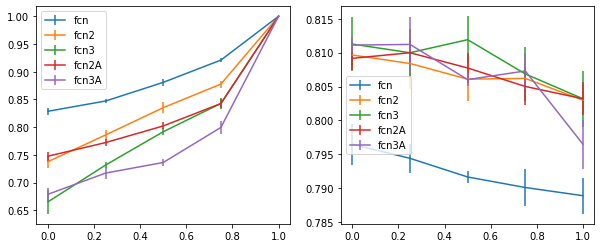

In [15]:
plot_corr_strength(2)

### Model Parameters

In [12]:
# Vbranch params
shared_frac_list = [0., 0.25, 0.5, 0.75, 1.]
num_branches = 2

vbranch_params = []
for frac in shared_frac_list:
    tf.reset_default_graph()
    inputs = tf.placeholder('float32', [None, 28,28,1])
    model = build_model(num_branches, frac)
#     model.summary()
    vbranch_params.append(model.count_parameters())

i  Layer name                Output shape   Num param  Inbound  
----------------------------------------------------------------
   Input                     [None,784]                         
----------------------------------------------------------------
   Input                     [None,784]                         
----------------------------------------------------------------
0  fc1 (Dense)               [] [None,512]  803840     input    
                             [] [None,512]                      
----------------------------------------------------------------
1  bn1 (BatchNormalization)  [] [None,512]  2048       fc1      
                             [] [None,512]                      
----------------------------------------------------------------
2  relu1 (Activation)        [] [None,512]  0          bn1      
                             [] [None,512]                      
----------------------------------------------------------------
3  fc2 (Dense)           

In [14]:
param_ratio = [p / vbranch_params[-1] for p in vbranch_params]
ideal_ratio = num_branches - np.array(shared_frac_list)**2 * (num_branches-1)

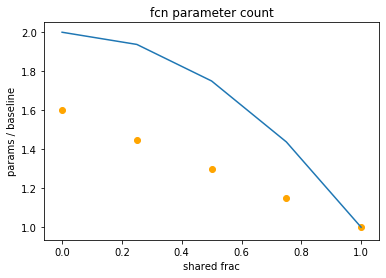

In [15]:
plt.scatter(shared_frac_list, param_ratio, color='orange')
# plt.plot(shared_frac_list, [1]*len(shared_frac_list))
plt.plot(shared_frac_list, ideal_ratio)

plt.xlabel('shared frac')
plt.ylabel('params / baseline')
plt.title('{} parameter count'.format(ARCHITECTURE))

plt.savefig('figs/cnn-small-parameter-count.png')
plt.show()